## Baseline on DDR+APTOS

In [5]:
# ============================================================================
# CELL 0: SETUP — Imports, Device, Logger
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import time
import copy
import platform
from datetime import datetime
from pathlib import Path
from scipy import stats
import pandas as pd
import os

# ── Device Setup ───────────────────────────────────────────────────────
os.environ.pop('CUDA_VISIBLE_DEVICES', None)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('=' * 70)
print('BASELINE COMPARISON SETUP')
print('=' * 70)
print(f'Device: {device}')
if device.type == 'cuda':
    print(f'GPU:    {torch.cuda.get_device_name(0)}')
    print(f'VRAM:   {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
    torch.backends.cudnn.benchmark = True
print('=' * 70)

# ── Safe num_workers ───────────────────────────────────────────────────
NUM_WORKERS = 0 if platform.system() == 'Windows' else 4
PIN_MEMORY  = device.type == 'cuda'
print(f'num_workers: {NUM_WORKERS}  pin_memory: {PIN_MEMORY}')

# ── Load your method results if available ──────────────────────────────
your_final_acc    = None
your_results      = None
your_client_accs  = None
your_std          = None

log_files = sorted(Path('./experiment_logs').glob('pFedPG*.json')) if Path('./experiment_logs').exists() else []
if log_files:
    with open(log_files[-1]) as f:
        your_results = json.load(f)
    your_final_acc   = your_results['final_results'].get('final_avg_acc')
    your_client_accs = your_results['rounds'][-1]['client_accs'] if your_results.get('rounds') else None
    your_std         = your_results['rounds'][-1].get('std_acc', 0.0) if your_results.get('rounds') else None
    print(f'\n✓ Loaded your method results: {log_files[-1].name}')
    print(f'  Final accuracy: {your_final_acc:.2f}%')
else:
    print('\n⚠ Your method results not found — will use placeholder for comparison table')

# ── Baseline Logger ────────────────────────────────────────────────────
class BaselineLogger:
    """Logs baseline results in same JSON format as proposed method."""
    def __init__(self, method_name, log_dir='./experiment_logs'):
        self.method_name = method_name
        self.log_dir     = Path(log_dir)
        self.log_dir.mkdir(exist_ok=True)

        self.start_time = datetime.now()
        timestamp       = self.start_time.strftime('%Y%m%d_%H%M%S')
        self.log_file   = self.log_dir / f'baseline_{method_name}_{timestamp}.json'

        self.data = {
            'method'      : method_name,
            'start_time'  : self.start_time.isoformat(),
            'device'      : str(device),
            'rounds'      : [],
            'final_results': {}
        }

    def log_round(self, round_num, metrics):
        self.data['rounds'].append({'round': round_num, **metrics})
        self._save()

    def log_final(self, final_metrics):
        self.data['final_results'] = final_metrics
        self.data['end_time'] = datetime.now().isoformat()
        self.data['total_time_minutes'] = (
            datetime.now() - self.start_time
        ).total_seconds() / 60
        self._save()
        print(f'\n✓ Logged: {self.log_file}')

    def _save(self):
        with open(self.log_file, 'w') as f:
            json.dump(self.data, f, indent=2)

print('\n✓ Setup complete')

BASELINE COMPARISON SETUP
Device: cuda
GPU:    NVIDIA RTX A6000
VRAM:   51.0 GB
num_workers: 4  pin_memory: True

✓ Loaded your method results: pFedPG_v3_BalAcc_FrozenPool_ps=20.json
  Final accuracy: 74.98%

✓ Setup complete


In [6]:
# ============================================================================
# CELL 1: DDR + APTOS Dataset Loaders
# 5 clients from DDR (clients 0-4) + 5 clients from APTOS (clients 5-9)
# ============================================================================

import os
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

DDR_PATH    = "./DR_grading/DR_grading"
APTOS_PATH  = "./train_images"
NUM_CLASSES = 5
LABEL_NAMES = ['NoDR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

TRAIN_TRANSFORM_FL = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

TEST_TRANSFORM_FL = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# ── DDR Dataset ────────────────────────────────────────────────────────
class DDRDataset(Dataset):
    """
    DDR Diabetic Retinopathy Dataset.
    id_code already has file extension (e.g. '001.jpg').
    Label 5 (Ungradable) is dropped automatically.
    5 classes: 0=NoDR, 1=Mild, 2=Moderate, 3=Severe, 4=Proliferative
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels      = labels
        self.transform   = transform

    @classmethod
    def from_folder(cls, data_path):
        data_path = Path(data_path)
        if not data_path.exists():
            raise FileNotFoundError(f"DDR folder not found: {data_path}")

        csv_path  = data_path / "DR_grading.csv"
        xlsx_path = data_path / "DR_grading.xlsx"

        if csv_path.exists():
            df = pd.read_csv(csv_path)
            print(f"  DDR: reading {csv_path}")
        elif xlsx_path.exists():
            df = pd.read_excel(xlsx_path)
            print(f"  DDR: reading {xlsx_path}")
        else:
            raise FileNotFoundError(f"No DR_grading.csv/.xlsx found in {data_path}")

        id_col, label_col = 'id_code', 'diagnosis'
        if id_col not in df.columns or label_col not in df.columns:
            id_col, label_col = df.columns[0], df.columns[1]
            print(f"  ⚠ Auto-detected columns: id='{id_col}'  label='{label_col}'")

        image_paths, labels_list = [], []
        skipped_nf, skipped_ug  = 0, 0

        for _, row in df.iterrows():
            label = int(row[label_col])
            if label > 4:
                skipped_ug += 1
                continue
            img_path = data_path / str(row[id_col]).strip()
            if not img_path.exists():
                skipped_nf += 1
                continue
            image_paths.append(img_path)
            labels_list.append(label)

        print(f"  DDR: {len(image_paths)} images loaded  "
              f"({skipped_ug} ungradable dropped, {skipped_nf} not found)")
        lbl_arr = np.array(labels_list)
        counts  = np.bincount(lbl_arr, minlength=NUM_CLASSES)
        total   = len(lbl_arr)
        for i, (name, cnt) in enumerate(zip(LABEL_NAMES, counts)):
            print(f"    Class {i} ({name:13s}): {cnt:5d}  ({100.*cnt/total:5.1f}%)")

        return cls(image_paths, labels_list, transform=None)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
        except Exception:
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, int(self.labels[idx])


# ── APTOS Dataset ──────────────────────────────────────────────────────
class APTOSDataset(Dataset):
    """
    APTOS 2019 Diabetic Retinopathy Dataset.
    id_code has NO extension in csv — .png appended automatically.
    5 classes: 0=NoDR, 1=Mild, 2=Moderate, 3=Severe, 4=Proliferative
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels      = labels
        self.transform   = transform

    @classmethod
    def from_folder(cls, data_path):
        data_path = Path(data_path)
        if not data_path.exists():
            raise FileNotFoundError(f"APTOS folder not found: {data_path}")

        csv_path  = data_path / "train.csv"
        xlsx_path = data_path / "train.xlsx"

        if csv_path.exists():
            df = pd.read_csv(csv_path)
            print(f"  APTOS: reading {csv_path}")
        elif xlsx_path.exists():
            df = pd.read_excel(xlsx_path)
            print(f"  APTOS: reading {xlsx_path}")
        else:
            raise FileNotFoundError(f"No train.csv/.xlsx found in {data_path}")

        image_paths, labels_list = [], []
        skipped = 0

        for _, row in df.iterrows():
            img_path = data_path / f"{row['id_code']}.png"
            if not img_path.exists():
                img_path = data_path / f"{row['id_code']}.jpg"
                if not img_path.exists():
                    skipped += 1
                    continue
            image_paths.append(img_path)
            labels_list.append(int(row['diagnosis']))

        print(f"  APTOS: {len(image_paths)} images loaded  ({skipped} not found)")
        lbl_arr = np.array(labels_list)
        counts  = np.bincount(lbl_arr, minlength=NUM_CLASSES)
        total   = len(lbl_arr)
        for i, (name, cnt) in enumerate(zip(LABEL_NAMES, counts)):
            print(f"    Class {i} ({name:13s}): {cnt:5d}  ({100.*cnt/total:5.1f}%)")

        return cls(image_paths, labels_list, transform=None)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
        except Exception:
            image = Image.new('RGB', (224, 224), color=(0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, int(self.labels[idx])


# ── Generic stratified federated split (works for any dataset class) ───
def stratified_federated_split(dataset_cls, image_paths, labels,
                                num_clients=5, train_ratio=0.8, seed=42):
    """
    Split a dataset pool into num_clients federated clients.
    Each client gets an equal, stratified share with its own train/test split.
    Returns list of dicts with train_dataset and test_dataset per client.
    """
    np.random.seed(seed)
    labels_arr  = np.array(labels)
    image_paths = list(image_paths)

    class_indices = {}
    for cls in range(NUM_CLASSES):
        idx = np.where(labels_arr == cls)[0].tolist()
        np.random.shuffle(idx)
        class_indices[cls] = idx

    client_pool = {k: [] for k in range(num_clients)}
    for cls in range(NUM_CLASSES):
        chunks = np.array_split(class_indices[cls], num_clients)
        for k, chunk in enumerate(chunks):
            client_pool[k].extend(chunk.tolist())

    clients = []
    for k in range(num_clients):
        pool        = np.array(client_pool[k])
        pool_labels = labels_arr[pool]

        train_idx, test_idx = [], []
        for cls in range(NUM_CLASSES):
            cls_mask = np.where(pool_labels == cls)[0]
            cls_pool = pool[cls_mask]
            np.random.shuffle(cls_pool)
            n_train  = max(1, int(len(cls_pool) * train_ratio))
            train_idx.extend(cls_pool[:n_train].tolist())
            test_idx.extend( cls_pool[n_train:].tolist())

        np.random.shuffle(train_idx)
        np.random.shuffle(test_idx)

        train_ds = dataset_cls(
            [image_paths[i] for i in train_idx],
            [int(labels_arr[i]) for i in train_idx],
            transform=TRAIN_TRANSFORM_FL
        )
        test_ds = dataset_cls(
            [image_paths[i] for i in test_idx],
            [int(labels_arr[i]) for i in test_idx],
            transform=TEST_TRANSFORM_FL
        )

        train_counts = np.bincount(labels_arr[train_idx], minlength=NUM_CLASSES)
        test_counts  = np.bincount(labels_arr[test_idx],  minlength=NUM_CLASSES)

        clients.append({
            'client_id'        : k,
            'train_dataset'    : train_ds,
            'test_dataset'     : test_ds,
            'train_size'       : len(train_ds),
            'test_size'        : len(test_ds),
            'label_counts'     : {int(c): int(train_counts[c]) for c in range(NUM_CLASSES)},
            'test_label_counts': {int(c): int(test_counts[c])  for c in range(NUM_CLASSES)},
        })

    return clients


print('✓ DDRDataset defined')
print('✓ APTOSDataset defined')
print('✓ stratified_federated_split defined')

# ── Load both datasets and build 10 clients ────────────────────────────
print("\n" + "=" * 70)
print("LOADING DATASETS")
print("=" * 70)

print("\n[1/2] Loading DDR...")
ddr_raw = DDRDataset.from_folder(DDR_PATH)

print("\n[2/2] Loading APTOS...")
aptos_raw = APTOSDataset.from_folder(APTOS_PATH)

# 5 DDR clients (clients 0-4)
print("\nCreating 5 DDR clients (seed=42)...")
ddr_clients = stratified_federated_split(
    DDRDataset, ddr_raw.image_paths, ddr_raw.labels,
    num_clients=5, seed=42
)

# 5 APTOS clients (clients 5-9)
print("\nCreating 5 APTOS clients (seed=42)...")
aptos_clients = stratified_federated_split(
    APTOSDataset, aptos_raw.image_paths, aptos_raw.labels,
    num_clients=5, seed=42
)

# Merge and re-index 0-9
all_clients = ddr_clients + aptos_clients
for i, c in enumerate(all_clients):
    c['client_id'] = i

num_clients    = len(all_clients)
train_datasets = [c['train_dataset'] for c in all_clients]
test_datasets  = [c['test_dataset']  for c in all_clients]

print(f"\n{'='*70}")
print(f"CLIENT SUMMARY  ({num_clients} total clients: 5 DDR + 5 APTOS)")
print(f"{'='*70}")
for c in all_clients:
    source = 'DDR  ' if c['client_id'] < 5 else 'APTOS'
    print(f"  Client {c['client_id']} ({source}): "
          f"train={c['train_size']:4d}  test={c['test_size']:4d}")
print(f"{'='*70}")
print(f"\n✓ All {num_clients} clients loaded  (NUM_CLASSES={NUM_CLASSES})")
print(f"  Classes: {', '.join(LABEL_NAMES)}")


✓ DDRDataset defined
✓ APTOSDataset defined
✓ stratified_federated_split defined

LOADING DATASETS

[1/2] Loading DDR...
  DDR: reading DR_grading/DR_grading/DR_grading.csv
  DDR: 12522 images loaded  (0 ungradable dropped, 0 not found)
    Class 0 (NoDR         ):  6266  ( 50.0%)
    Class 1 (Mild         ):   630  (  5.0%)
    Class 2 (Moderate     ):  4477  ( 35.8%)
    Class 3 (Severe       ):   236  (  1.9%)
    Class 4 (Proliferative):   913  (  7.3%)

[2/2] Loading APTOS...
  APTOS: reading train_images/train.csv
  APTOS: 3662 images loaded  (0 not found)
    Class 0 (NoDR         ):  1805  ( 49.3%)
    Class 1 (Mild         ):   370  ( 10.1%)
    Class 2 (Moderate     ):   999  ( 27.3%)
    Class 3 (Severe       ):   193  (  5.3%)
    Class 4 (Proliferative):   295  (  8.1%)

Creating 5 DDR clients (seed=42)...

Creating 5 APTOS clients (seed=42)...

CLIENT SUMMARY  (10 total clients: 5 DDR + 5 APTOS)
  Client 0 (DDR  ): train=2003  test= 504
  Client 1 (DDR  ): train=2001  tes

In [7]:
# ============================================================================
# CELL 2: ViT-Base Backbone — SAME as proposed method (unchanged)
# ============================================================================

import timm

class ViTBackbone(nn.Module):
    """
    ViT-Base/16 ImageNet-21k — FROZEN.
    Shared across ALL baselines and proposed method for fair comparison.
    """
    def __init__(self, pretrained=True):
        super().__init__()
        print('\n  Loading ViT-Base/16...')

        vit_with_head = timm.create_model('vit_base_patch16_224', pretrained=pretrained, num_classes=21843)
        self.embed_dim     = 768
        self.pretrained_head = None

        if pretrained and hasattr(vit_with_head, 'head') and isinstance(vit_with_head.head, nn.Linear):
            h = vit_with_head.head
            self.pretrained_head = {
                'weight'      : h.weight.data.clone(),
                'bias'        : h.bias.data.clone() if h.bias is not None else None,
                'in_features' : h.in_features,
                'out_features': h.out_features
            }
            print(f'  ✓ Pretrained head extracted: [{h.in_features} → {h.out_features}]')

        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained, num_classes=0, global_pool='')
        for p in self.vit.parameters():
            p.requires_grad = False
        self.vit.eval()
        del vit_with_head

        print(f'  ✓ ViT-Base frozen: {sum(p.numel() for p in self.vit.parameters()):,} params')

    def forward(self, x):
        with torch.no_grad():
            return self.vit.forward_features(x)[:, 0]

    def get_feature_dim(self):
        return self.embed_dim

    def has_pretrained_head(self):
        return self.pretrained_head is not None

    def get_pretrained_head_weights(self):
        return self.pretrained_head


print('✓ ViTBackbone defined')

# ── Load ONE shared backbone for ALL baselines ─────────────────────────
# Loading once avoids downloading pretrained weights multiple times
print('\nLoading shared backbone (used by all baselines)...')
shared_backbone = ViTBackbone(pretrained=True).to(device)
print('✓ Shared backbone ready')

✓ ViTBackbone defined

Loading shared backbone (used by all baselines)...

  Loading ViT-Base/16...
  ✓ Pretrained head extracted: [768 → 21843]


  ✓ ViT-Base frozen: 85,798,656 params
✓ Shared backbone ready


In [8]:
# ============================================================================
# CELL 3: Shared Classifier Architecture
# Used identically by Local-Only, Central, FedAvg, and Fine-tune baselines
# SAME architecture as proposed method for fair comparison
# ============================================================================

class BaselineModel(nn.Module):
    """
    Frozen ViT backbone + trainable classifier head.
    Architecture identical to proposed method:
      LayerNorm(768) → Linear(768→512) → GELU → Dropout(0.1) → Linear(512→8)

    Both Linear layers initialized from ViT-21k pretrained head weights.
    Backbone is NEVER trained or aggregated — only classifier head is.

    FIX vs original: added Layer[4] pretrained init (was random before)
    """
    def __init__(self, backbone, num_classes=5):
        super().__init__()
        self.backbone = backbone

        self.classifier = nn.Sequential(
            nn.LayerNorm(768),           # [0]
            nn.Linear(768, 512),         # [1]
            nn.GELU(),                   # [2]
            nn.Dropout(0.1),             # [3]
            nn.Linear(512, num_classes)  # [4]
        )

        # Initialize BOTH linear layers from pretrained ViT head
        if backbone.has_pretrained_head():
            pre = backbone.get_pretrained_head_weights()
            w   = pre['weight']  # [21843, 768]
            b   = pre['bias']    # [21843]
            with torch.no_grad():
                # Layer[1]: 768 → 512
                self.classifier[1].weight.data = w[:512, :].clone()
                self.classifier[1].bias.data   = b[:512].clone()
                # Layer[4]: 512 → num_classes
                self.classifier[4].weight.data = w[:num_classes, :512].clone()
                self.classifier[4].bias.data   = b[:num_classes].clone()
            print('  ✓ Both classifier layers initialized from ViT pretrained head')

        n_params = sum(p.numel() for p in self.classifier.parameters())
        print(f'  Trainable classifier params: {n_params:,}')

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)   # [B, 768] frozen
        return self.classifier(features)  # [B, 8]


print('✓ BaselineModel defined')
print('  Same architecture as proposed method')
print('  Both Linear layers use pretrained ViT-21k init')

✓ BaselineModel defined
  Same architecture as proposed method
  Both Linear layers use pretrained ViT-21k init


In [9]:
# ============================================================================
# CELL 4: Shared Training Utilities
# compute_validation_loss and evaluate used by ALL baselines
# patience=3 on val_loss — SAME stopping criterion as proposed method
# ============================================================================

def compute_validation_loss(model, loader, criterion, device):
    """Compute val loss on test set. Used for patience-based stopping."""
    model.eval()
    total_loss  = 0.0
    batch_count = 0
    use_amp     = (device.type == 'cuda')

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast('cuda', enabled=use_amp):
                loss = criterion(model(images), labels)
            total_loss  += loss.item()
            batch_count += 1

    return total_loss / max(batch_count, 1)


def evaluate_accuracy(model, loader, device):
    """Compute test accuracy."""
    model.eval()
    correct = 0
    total   = 0
    use_amp = (device.type == 'cuda')

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = model(images)
            _, predicted = outputs.max(1)
            total   += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total


def train_with_patience(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    device, client_id=0, method_name='',
    max_epochs=10, min_epochs=2, patience=3, val_threshold=0.001
):
    """
    Train with PATIENCE=3 on VALIDATION LOSS.

    Rules (same as proposed method):
      - Always run min_epochs
      - After each epoch: compute val_loss
      - If val_loss did NOT drop by val_threshold → patience counter +1
      - If patience counter reaches patience limit → STOP
      - Hard cap at max_epochs

    Returns: (best_val_loss, final_train_acc, stop_epoch)
    """
    use_amp = (device.type == 'cuda')
    scaler  = torch.amp.GradScaler('cuda', enabled=use_amp)

    best_val_loss    = float('inf')
    patience_counter = 0
    stop_epoch       = max_epochs
    final_train_acc  = 0.0

    print(f'  [{method_name}] Client {client_id} | '
          f'patience={patience} val_threshold={val_threshold}')

    for epoch in range(1, max_epochs + 1):

        # ── Train one full epoch ───────────────────────────────────
        model.train()
        running_loss = 0.0
        correct      = 0
        total        = 0

        pbar = tqdm(
            train_loader,
            desc=f'    Epoch {epoch}/{max_epochs}',
            leave=False
        )

        for images, labels in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = model(images)
                loss    = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted  = outputs.max(1)
            total        += labels.size(0)
            correct      += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.3f}',
                'acc' : f'{100.*correct/total:.1f}%'
            })

        if scheduler is not None:
            scheduler.step()

        train_acc    = 100. * correct / total
        train_loss   = running_loss / len(train_loader)
        final_train_acc = train_acc

        # ── Patience check on val_loss ─────────────────────────────
        val_loss    = compute_validation_loss(model, val_loader, criterion, device)
        improvement = best_val_loss - val_loss

        if improvement >= val_threshold:
            best_val_loss    = val_loss
            patience_counter = 0
            status = f'✓ val {val_loss:.4f}'
        else:
            patience_counter += 1
            status = f'✗ no improve ({patience_counter}/{patience}) val={val_loss:.4f}'

        print(f'    Epoch {epoch}/{max_epochs}: '
              f'TrainLoss={train_loss:.4f}, '
              f'TrainAcc={train_acc:.2f}%, '
              f'ValLoss={val_loss:.4f} | {status}')

        if epoch >= min_epochs and patience_counter >= patience:
            print(f'    ⏹ Early stop at epoch {epoch} '
                  f'(best val={best_val_loss:.4f})')
            stop_epoch = epoch
            break

    return best_val_loss, final_train_acc, stop_epoch


print('✓ Shared training utilities defined')
print('  compute_validation_loss, evaluate_accuracy, train_with_patience')
print('  patience=3 on val_loss — same as proposed method')

✓ Shared training utilities defined
  compute_validation_loss, evaluate_accuracy, train_with_patience
  patience=3 on val_loss — same as proposed method


In [ ]:
# ============================================================================
# CELL 5: BASELINE 1 — LOCAL-ONLY TRAINING
# ============================================================================

print('\n' + '=' * 70)
print('BASELINE 1: LOCAL-ONLY TRAINING (Lower Bound)')
print('=' * 70)
print('Each client trains independently — NO collaboration')
print('patience=3 on validation loss')
print('=' * 70)

logger_local  = BaselineLogger('local_only')
local_results = []   # final test accuracy per client
local_vlosses = []   # best val loss per client

for client_id in range(num_clients):
    print(f'\n{"-" * 60}')
    print(f'Local-Only: Client {client_id}')
    print(f'{"-" * 60}')

    train_loader = DataLoader(
        train_datasets[client_id], batch_size=64, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0)
    )
    test_loader = DataLoader(
        test_datasets[client_id], batch_size=64, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0)
    )

    # Use shared backbone — NOT a new ViTBackbone() each time
    model     = BaselineModel(shared_backbone, num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.classifier.parameters(),   # classifier head ONLY
        lr=1e-3, weight_decay=0.01
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    best_vl, final_train_acc, stop_ep = train_with_patience(
        model, train_loader, test_loader, criterion, optimizer, scheduler,
        device, client_id=client_id, method_name='LocalOnly',
        max_epochs=10, min_epochs=2, patience=3
    )

    test_acc = evaluate_accuracy(model, test_loader, device)
    local_results.append(test_acc)
    local_vlosses.append(best_vl)

    print(f'  ✓ Client {client_id}: TestAcc={test_acc:.2f}%, '
          f'BestValLoss={best_vl:.4f}, Epochs={stop_ep}')

    if device.type == 'cuda':
        torch.cuda.empty_cache()

avg_local = np.mean(local_results)
std_local = np.std(local_results)

print('\n' + '=' * 70)
print('LOCAL-ONLY RESULTS')
print('=' * 70)
for i, acc in enumerate(local_results):
    print(f'  Client {i}: {acc:.2f}%  (val_loss={local_vlosses[i]:.4f})')
print(f'\n  Average: {avg_local:.2f}% ± {std_local:.2f}%')
print('=' * 70)

logger_local.log_final({
    'final_avg_acc': avg_local,
    'std_acc'      : std_local,
    'client_accs'  : local_results,
    'val_losses'   : local_vlosses
})
print(f'\n✓ Local-Only complete: {avg_local:.2f}%')


BASELINE 1: LOCAL-ONLY TRAINING (Lower Bound)
Each client trains independently — NO collaboration
patience=3 on validation loss

------------------------------------------------------------
Local-Only: Client 0
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 0 | patience=3 val_threshold=0.001


    Epoch 1/10:   0%|          | 0/32 [00:00<?, ?it/s]

    Epoch 1/10: TrainLoss=0.9986, TrainAcc=58.76%, ValLoss=0.8480 | ✓ val 0.8480


    Epoch 2/10: TrainLoss=0.8009, TrainAcc=68.10%, ValLoss=0.9017 | ✗ no improve (1/3) val=0.9017


    Epoch 3/10: TrainLoss=0.7418, TrainAcc=70.29%, ValLoss=0.9444 | ✗ no improve (2/3) val=0.9444


    Epoch 4/10: TrainLoss=0.7583, TrainAcc=69.05%, ValLoss=0.8288 | ✓ val 0.8288


    Epoch 5/10: TrainLoss=0.7122, TrainAcc=71.64%, ValLoss=0.7661 | ✓ val 0.7661


    Epoch 6/10: TrainLoss=0.7008, TrainAcc=72.09%, ValLoss=0.7774 | ✗ no improve (1/3) val=0.7774


    Epoch 7/10: TrainLoss=0.6737, TrainAcc=74.24%, ValLoss=0.7729 | ✗ no improve (2/3) val=0.7729


    Epoch 8/10: TrainLoss=0.6467, TrainAcc=75.79%, ValLoss=0.7697 | ✗ no improve (3/3) val=0.7697
    ⏹ Early stop at epoch 8 (best val=0.7661)
  ✓ Client 0: TestAcc=69.64%, BestValLoss=0.7661, Epochs=8

------------------------------------------------------------
Local-Only: Client 1
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 1 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.0462, TrainAcc=60.42%, ValLoss=0.8163 | ✓ val 0.8163


    Epoch 2/10: TrainLoss=0.8532, TrainAcc=68.27%, ValLoss=0.7916 | ✓ val 0.7916


    Epoch 3/10: TrainLoss=0.8153, TrainAcc=68.17%, ValLoss=0.7522 | ✓ val 0.7522


    Epoch 4/10: TrainLoss=0.7662, TrainAcc=71.46%, ValLoss=0.7513 | ✗ no improve (1/3) val=0.7513


    Epoch 5/10: TrainLoss=0.7585, TrainAcc=69.62%, ValLoss=0.7716 | ✗ no improve (2/3) val=0.7716


    Epoch 6/10: TrainLoss=0.7323, TrainAcc=72.16%, ValLoss=0.7483 | ✓ val 0.7483


    Epoch 7/10: TrainLoss=0.7097, TrainAcc=73.71%, ValLoss=0.7172 | ✓ val 0.7172


    Epoch 8/10: TrainLoss=0.6864, TrainAcc=73.71%, ValLoss=0.7347 | ✗ no improve (1/3) val=0.7347


    Epoch 9/10: TrainLoss=0.6689, TrainAcc=74.31%, ValLoss=0.7090 | ✓ val 0.7090


    Epoch 10/10: TrainLoss=0.6681, TrainAcc=74.46%, ValLoss=0.7120 | ✗ no improve (1/3) val=0.7120
  ✓ Client 1: TestAcc=75.20%, BestValLoss=0.7090, Epochs=10

------------------------------------------------------------
Local-Only: Client 2
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 2 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.9752, TrainAcc=62.32%, ValLoss=0.8619 | ✓ val 0.8619


    Epoch 2/10: TrainLoss=0.7975, TrainAcc=69.52%, ValLoss=0.8393 | ✓ val 0.8393


    Epoch 3/10: TrainLoss=0.7812, TrainAcc=70.51%, ValLoss=0.8104 | ✓ val 0.8104


    Epoch 4/10: TrainLoss=0.7222, TrainAcc=73.01%, ValLoss=0.8458 | ✗ no improve (1/3) val=0.8458


    Epoch 5/10: TrainLoss=0.7003, TrainAcc=72.91%, ValLoss=0.8273 | ✗ no improve (2/3) val=0.8273


    Epoch 6/10: TrainLoss=0.6990, TrainAcc=74.16%, ValLoss=0.7665 | ✓ val 0.7665


    Epoch 7/10: TrainLoss=0.6505, TrainAcc=74.86%, ValLoss=0.7805 | ✗ no improve (1/3) val=0.7805


    Epoch 8/10: TrainLoss=0.6468, TrainAcc=75.26%, ValLoss=0.7598 | ✓ val 0.7598


    Epoch 9/10: TrainLoss=0.6442, TrainAcc=76.41%, ValLoss=0.7591 | ✗ no improve (1/3) val=0.7591


    Epoch 10/10: TrainLoss=0.6260, TrainAcc=76.41%, ValLoss=0.7582 | ✓ val 0.7582
  ✓ Client 2: TestAcc=71.37%, BestValLoss=0.7582, Epochs=10

------------------------------------------------------------
Local-Only: Client 3
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 3 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.0034, TrainAcc=57.40%, ValLoss=0.9018 | ✓ val 0.9018


    Epoch 2/10: TrainLoss=0.8376, TrainAcc=67.40%, ValLoss=0.8732 | ✓ val 0.8732


    Epoch 3/10: TrainLoss=0.8084, TrainAcc=68.25%, ValLoss=0.8401 | ✓ val 0.8401


    Epoch 4/10: TrainLoss=0.7601, TrainAcc=70.65%, ValLoss=0.8192 | ✓ val 0.8192


    Epoch 5/10: TrainLoss=0.7335, TrainAcc=71.95%, ValLoss=0.7992 | ✓ val 0.7992


    Epoch 6/10: TrainLoss=0.6884, TrainAcc=73.55%, ValLoss=0.8470 | ✗ no improve (1/3) val=0.8470


    Epoch 7/10: TrainLoss=0.6913, TrainAcc=73.85%, ValLoss=0.7943 | ✓ val 0.7943


    Epoch 8/10: TrainLoss=0.6767, TrainAcc=73.40%, ValLoss=0.7842 | ✓ val 0.7842


    Epoch 9/10: TrainLoss=0.6527, TrainAcc=74.45%, ValLoss=0.7873 | ✗ no improve (1/3) val=0.7873


    Epoch 10/10: TrainLoss=0.6415, TrainAcc=75.90%, ValLoss=0.7801 | ✓ val 0.7801
  ✓ Client 3: TestAcc=71.37%, BestValLoss=0.7801, Epochs=10

------------------------------------------------------------
Local-Only: Client 4
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 4 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.0103, TrainAcc=59.50%, ValLoss=0.8344 | ✓ val 0.8344


    Epoch 2/10: TrainLoss=0.8573, TrainAcc=67.65%, ValLoss=0.7858 | ✓ val 0.7858


    Epoch 3/10: TrainLoss=0.7673, TrainAcc=70.40%, ValLoss=0.7643 | ✓ val 0.7643


    Epoch 4/10: TrainLoss=0.7402, TrainAcc=70.60%, ValLoss=0.7327 | ✓ val 0.7327


    Epoch 5/10: TrainLoss=0.7185, TrainAcc=71.85%, ValLoss=0.7191 | ✓ val 0.7191


    Epoch 6/10: TrainLoss=0.7185, TrainAcc=71.25%, ValLoss=0.7151 | ✓ val 0.7151


    Epoch 7/10: TrainLoss=0.6826, TrainAcc=73.60%, ValLoss=0.7198 | ✗ no improve (1/3) val=0.7198


    Epoch 8/10: TrainLoss=0.6630, TrainAcc=74.85%, ValLoss=0.7211 | ✗ no improve (2/3) val=0.7211


    Epoch 9/10: TrainLoss=0.6567, TrainAcc=75.15%, ValLoss=0.6990 | ✓ val 0.6990


    Epoch 10/10: TrainLoss=0.6464, TrainAcc=76.25%, ValLoss=0.6950 | ✓ val 0.6950
  ✓ Client 4: TestAcc=74.75%, BestValLoss=0.6950, Epochs=10

------------------------------------------------------------
Local-Only: Client 5
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 5 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.2423, TrainAcc=53.85%, ValLoss=1.0606 | ✓ val 1.0606


    Epoch 2/10: TrainLoss=0.8490, TrainAcc=72.31%, ValLoss=0.9307 | ✓ val 0.9307


    Epoch 3/10: TrainLoss=0.6570, TrainAcc=75.38%, ValLoss=0.8453 | ✓ val 0.8453


    Epoch 4/10: TrainLoss=0.6365, TrainAcc=75.04%, ValLoss=0.8202 | ✓ val 0.8202


    Epoch 5/10: TrainLoss=0.5590, TrainAcc=78.29%, ValLoss=0.7647 | ✓ val 0.7647


    Epoch 6/10: TrainLoss=0.5831, TrainAcc=79.32%, ValLoss=0.7994 | ✗ no improve (1/3) val=0.7994


    Epoch 7/10: TrainLoss=0.5290, TrainAcc=83.93%, ValLoss=0.7505 | ✓ val 0.7505


    Epoch 8/10: TrainLoss=0.4843, TrainAcc=82.05%, ValLoss=0.7971 | ✗ no improve (1/3) val=0.7971


    Epoch 9/10: TrainLoss=0.4726, TrainAcc=81.88%, ValLoss=0.7734 | ✗ no improve (2/3) val=0.7734


    Epoch 10/10: TrainLoss=0.4774, TrainAcc=82.56%, ValLoss=0.7591 | ✗ no improve (3/3) val=0.7591
    ⏹ Early stop at epoch 10 (best val=0.7505)
  ✓ Client 5: TestAcc=72.30%, BestValLoss=0.7505, Epochs=10

------------------------------------------------------------
Local-Only: Client 6
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 6 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.0867, TrainAcc=56.41%, ValLoss=0.8671 | ✓ val 0.8671


    Epoch 2/10: TrainLoss=0.7866, TrainAcc=71.11%, ValLoss=0.7869 | ✓ val 0.7869


    Epoch 3/10: TrainLoss=0.7476, TrainAcc=72.31%, ValLoss=0.8502 | ✗ no improve (1/3) val=0.8502


    Epoch 4/10: TrainLoss=0.6420, TrainAcc=76.07%, ValLoss=0.9130 | ✗ no improve (2/3) val=0.9130


    Epoch 5/10: TrainLoss=0.6287, TrainAcc=75.90%, ValLoss=0.7106 | ✓ val 0.7106


    Epoch 6/10: TrainLoss=0.5394, TrainAcc=79.66%, ValLoss=0.7570 | ✗ no improve (1/3) val=0.7570


    Epoch 7/10: TrainLoss=0.5671, TrainAcc=79.49%, ValLoss=0.7061 | ✓ val 0.7061


    Epoch 8/10: TrainLoss=0.5156, TrainAcc=81.20%, ValLoss=0.6938 | ✓ val 0.6938


    Epoch 9/10: TrainLoss=0.5025, TrainAcc=80.17%, ValLoss=0.6973 | ✗ no improve (1/3) val=0.6973


    Epoch 10/10: TrainLoss=0.5107, TrainAcc=82.05%, ValLoss=0.6951 | ✗ no improve (2/3) val=0.6951
  ✓ Client 6: TestAcc=81.08%, BestValLoss=0.6938, Epochs=10

------------------------------------------------------------
Local-Only: Client 7
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 7 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.1554, TrainAcc=58.12%, ValLoss=0.9589 | ✓ val 0.9589


    Epoch 2/10: TrainLoss=0.7455, TrainAcc=73.50%, ValLoss=0.8123 | ✓ val 0.8123


    Epoch 3/10: TrainLoss=0.6428, TrainAcc=76.07%, ValLoss=0.7469 | ✓ val 0.7469


    Epoch 4/10: TrainLoss=0.6175, TrainAcc=78.12%, ValLoss=0.7868 | ✗ no improve (1/3) val=0.7868


    Epoch 5/10: TrainLoss=0.6388, TrainAcc=78.29%, ValLoss=0.7829 | ✗ no improve (2/3) val=0.7829


    Epoch 6/10: TrainLoss=0.5513, TrainAcc=79.83%, ValLoss=0.7603 | ✗ no improve (3/3) val=0.7603
    ⏹ Early stop at epoch 6 (best val=0.7469)
  ✓ Client 7: TestAcc=73.65%, BestValLoss=0.7469, Epochs=6

------------------------------------------------------------
Local-Only: Client 8
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 8 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.2165, TrainAcc=56.85%, ValLoss=1.0140 | ✓ val 1.0140


    Epoch 2/10: TrainLoss=0.8158, TrainAcc=69.86%, ValLoss=0.8532 | ✓ val 0.8532


    Epoch 3/10: TrainLoss=0.6631, TrainAcc=74.14%, ValLoss=0.8020 | ✓ val 0.8020


    Epoch 4/10: TrainLoss=0.5964, TrainAcc=76.20%, ValLoss=0.7155 | ✓ val 0.7155


    Epoch 5/10: TrainLoss=0.5758, TrainAcc=79.97%, ValLoss=0.7450 | ✗ no improve (1/3) val=0.7450


    Epoch 6/10: TrainLoss=0.5765, TrainAcc=79.79%, ValLoss=0.7831 | ✗ no improve (2/3) val=0.7831


    Epoch 7/10: TrainLoss=0.5428, TrainAcc=79.45%, ValLoss=0.7671 | ✗ no improve (3/3) val=0.7671
    ⏹ Early stop at epoch 7 (best val=0.7155)
  ✓ Client 8: TestAcc=73.65%, BestValLoss=0.7155, Epochs=7

------------------------------------------------------------
Local-Only: Client 9
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [LocalOnly] Client 9 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.1094, TrainAcc=54.55%, ValLoss=1.0941 | ✓ val 1.0941


    Epoch 2/10: TrainLoss=0.7621, TrainAcc=71.01%, ValLoss=1.0167 | ✓ val 1.0167


    Epoch 3/10: TrainLoss=0.7175, TrainAcc=72.56%, ValLoss=0.9431 | ✓ val 0.9431


    Epoch 4/10: TrainLoss=0.6350, TrainAcc=75.13%, ValLoss=0.8497 | ✓ val 0.8497


    Epoch 5/10: TrainLoss=0.5582, TrainAcc=78.90%, ValLoss=0.8270 | ✓ val 0.8270


    Epoch 6/10: TrainLoss=0.5833, TrainAcc=77.53%, ValLoss=0.8318 | ✗ no improve (1/3) val=0.8318


    Epoch 7/10: TrainLoss=0.5387, TrainAcc=80.62%, ValLoss=0.7720 | ✓ val 0.7720


    Epoch 8/10: TrainLoss=0.5630, TrainAcc=80.10%, ValLoss=0.8000 | ✗ no improve (1/3) val=0.8000


    Epoch 9/10: TrainLoss=0.4997, TrainAcc=81.82%, ValLoss=0.7845 | ✗ no improve (2/3) val=0.7845


    Epoch 10/10: TrainLoss=0.5169, TrainAcc=80.79%, ValLoss=0.7826 | ✗ no improve (3/3) val=0.7826
    ⏹ Early stop at epoch 10 (best val=0.7720)
  ✓ Client 9: TestAcc=71.62%, BestValLoss=0.7720, Epochs=10

LOCAL-ONLY RESULTS
  Client 0: 69.64%  (val_loss=0.7661)
  Client 1: 75.20%  (val_loss=0.7090)
  Client 2: 71.37%  (val_loss=0.7582)
  Client 3: 71.37%  (val_loss=0.7801)
  Client 4: 74.75%  (val_loss=0.6950)
  Client 5: 72.30%  (val_loss=0.7505)
  Client 6: 81.08%  (val_loss=0.6938)
  Client 7: 73.65%  (val_loss=0.7469)
  Client 8: 73.65%  (val_loss=0.7155)
  Client 9: 71.62%  (val_loss=0.7720)

  Average: 73.46% ± 3.01%

✓ Logged: experiment_logs/baseline_local_only_20260226_201038.json

✓ Local-Only complete: 73.46%


In [ ]:
# ============================================================================
# CELL 6: BASELINE 2 — CENTRAL TRAINING
# ============================================================================

print('\n' + '=' * 70)
print('BASELINE 2: CENTRAL TRAINING (Upper Bound)')
print('=' * 70)
print('All data pooled — no privacy constraint')
print('patience=3 on validation loss')
print('=' * 70)

central_train_dataset = ConcatDataset(train_datasets)
central_test_dataset  = ConcatDataset(test_datasets)

central_train_loader = DataLoader(
    central_train_dataset, batch_size=64, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=(NUM_WORKERS > 0)
)
central_test_loader = DataLoader(
    central_test_dataset, batch_size=64, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=(NUM_WORKERS > 0)
)

print(f'Total train samples: {len(central_train_dataset)}')
print(f'Total test samples:  {len(central_test_dataset)}')

logger_central = BaselineLogger('central')

central_model = BaselineModel(shared_backbone, num_classes=5).to(device)
criterion_c   = nn.CrossEntropyLoss()
optimizer_c   = optim.AdamW(
    central_model.classifier.parameters(),
    lr=1e-3, weight_decay=0.01
)
scheduler_c   = optim.lr_scheduler.CosineAnnealingLR(optimizer_c, T_max=10)

best_vl_c, _, stop_ep_c = train_with_patience(
    central_model, central_train_loader, central_test_loader,
    criterion_c, optimizer_c, scheduler_c,
    device, client_id=0, method_name='Central',
    max_epochs=10, min_epochs=2, patience=3
)

central_acc = evaluate_accuracy(central_model, central_test_loader, device)

print(f'\n✓ Central Training: {central_acc:.2f}%  '
      f'BestValLoss={best_vl_c:.4f}  Epochs={stop_ep_c}')

logger_central.log_final({
    'final_avg_acc': central_acc,
    'best_val_loss': best_vl_c,
    'stop_epoch'   : stop_ep_c
})

if device.type == 'cuda':
    torch.cuda.empty_cache()


BASELINE 2: CENTRAL TRAINING (Upper Bound)
All data pooled — no privacy constraint
patience=3 on validation loss
Total train samples: 12927
Total test samples:  3257
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [Central] Client 0 | patience=3 val_threshold=0.001


    Epoch 1/10:   0%|          | 0/202 [00:00<?, ?it/s]

    Epoch 1/10: TrainLoss=0.8482, TrainAcc=68.17%, ValLoss=0.7584 | ✓ val 0.7584


    Epoch 2/10: TrainLoss=0.7527, TrainAcc=71.50%, ValLoss=0.7223 | ✓ val 0.7223


    Epoch 3/10: TrainLoss=0.7136, TrainAcc=73.07%, ValLoss=0.7385 | ✗ no improve (1/3) val=0.7385


    Epoch 4/10: TrainLoss=0.6931, TrainAcc=74.07%, ValLoss=0.6895 | ✓ val 0.6895


    Epoch 5/10: TrainLoss=0.6692, TrainAcc=74.90%, ValLoss=0.6950 | ✗ no improve (1/3) val=0.6950


    Epoch 6/10: TrainLoss=0.6462, TrainAcc=75.43%, ValLoss=0.7080 | ✗ no improve (2/3) val=0.7080


    Epoch 7/10: TrainLoss=0.6350, TrainAcc=76.08%, ValLoss=0.6888 | ✗ no improve (3/3) val=0.6888
    ⏹ Early stop at epoch 7 (best val=0.6895)

✓ Central Training: 75.25%  BestValLoss=0.6895  Epochs=7

✓ Logged: experiment_logs/baseline_central_20260226_205207.json


In [ ]:
# ============================================================================
# CELL 7: FEDAVG — FedAvgModel, FedAvgClient, FedAvgServer
# ============================================================================

# ── FedAvgClient ───────────────────────────────────────────────────────
class FedAvgClient:
    """
    FedAvg client — trains ONLY the classifier head.
    Backbone is frozen and NEVER sent to server.
    patience=3 on validation loss — same as proposed method.
    """
    def __init__(self, client_id, train_dataset, test_dataset, backbone, device):
        self.client_id    = client_id
        self.device       = device
        self.dataset_size = len(train_dataset)

        self.train_loader = DataLoader(
            train_dataset, batch_size=64, shuffle=True,
            num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
            persistent_workers=(NUM_WORKERS > 0)
        )
        self.test_loader = DataLoader(
            test_dataset, batch_size=64, shuffle=False,
            num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
            persistent_workers=(NUM_WORKERS > 0)
        )

        # Same model architecture as proposed method
        self.model     = BaselineModel(backbone, num_classes=5).to(device)
        self.criterion = nn.CrossEntropyLoss()

        print(f'  FedAvgClient {client_id}: {self.dataset_size} samples')

    def set_weights(self, global_weights):
        """Load ONLY classifier weights from server."""
        self.model.classifier.load_state_dict(copy.deepcopy(global_weights))

    def get_weights(self):
        """Return ONLY classifier weights — backbone never shared."""
        return copy.deepcopy(self.model.classifier.state_dict())

    def train(self, lr=1e-4, max_epochs=10, min_epochs=2,
              patience=3, val_threshold=0.001):
        """
        Train classifier head with patience=3 on validation loss.
        Returns: (classifier_weights, dataset_size, best_val_loss)
        """
        optimizer = optim.AdamW(
            self.model.classifier.parameters(),   # HEAD ONLY — NOT full model
            lr=lr, weight_decay=0.01
        )
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

        best_vl, _, stop_ep = train_with_patience(
            self.model, self.train_loader, self.test_loader,
            self.criterion, optimizer, scheduler,
            self.device, client_id=self.client_id, method_name='FedAvg',
            max_epochs=max_epochs, min_epochs=min_epochs,
            patience=patience, val_threshold=val_threshold
        )

        print(f'  Client {self.client_id}: '
              f'BestVal={best_vl:.4f}, Epochs={stop_ep}')

        return self.get_weights(), self.dataset_size, best_vl

    def evaluate(self):
        return evaluate_accuracy(self.model, self.test_loader, self.device)


# ── FedAvgServer ───────────────────────────────────────────────────────
class FedAvgServer:
    """
    FedAvg server — aggregates ONLY classifier head weights.
    Communication cost = classifier params only, NOT 86M backbone.
    Logs every round to JSON — same format as proposed method for fair plotting.
    """
    def __init__(self, backbone, num_clients, device):
        self.device      = device
        self.num_clients = num_clients

        # Global model — shares same backbone as all clients
        self.global_model = BaselineModel(backbone, num_classes=5).to(device)
        self.results      = []

        n_classifier = sum(p.numel() for p in self.global_model.classifier.parameters())
        print(f'\n  FedAvgServer:')
        print(f'    Aggregates:   classifier head only')
        print(f'    Params/round: {n_classifier:,}')

    def get_global_weights(self):
        """Return ONLY classifier weights."""
        return copy.deepcopy(self.global_model.classifier.state_dict())

    def aggregate(self, client_weights, client_sizes):
        """FedAvg on classifier head: W_global = Σ (|D_n|/|D|) × W_n"""
        total  = sum(client_sizes)
        result = {}
        for key in client_weights[0].keys():
            result[key] = sum(
                client_weights[i][key].to(self.device) * (client_sizes[i] / total)
                for i in range(len(client_weights))
            )
        self.global_model.classifier.load_state_dict(result)

    def run(self, train_datasets, test_datasets, num_rounds=20,
            logger=None, lr=1e-4, max_epochs=10, min_epochs=2, patience=3):
        """
        Full FedAvg training loop.
        Evaluates every round — same structure as proposed method.
        """
        backbone = self.global_model.backbone

        clients = [
            FedAvgClient(i, train_datasets[i], test_datasets[i], backbone, self.device)
            for i in range(self.num_clients)
        ]

        print('\n' + '=' * 70)
        print('FEDAVG TRAINING')
        print('=' * 70)
        print(f'Rounds:         {num_rounds}')
        print(f'Max epochs:     {max_epochs}')
        print(f'Patience:       {patience} (on val loss)')
        print(f'Training:       classifier head only (backbone frozen)')
        print('=' * 70)

        best_avg_acc = 0.0

        for round_num in range(1, num_rounds + 1):
            print(f'\n{"=" * 70}')
            print(f'FEDAVG ROUND {round_num}/{num_rounds}')
            print(f'{"=" * 70}')
            round_start = time.time()

            # ── Distribute global weights ──────────────────────────
            global_w = self.get_global_weights()
            for client in clients:
                client.set_weights(global_w)

            # ── Local training with patience ───────────────────────
            print('\n[Phase 1] Local training...')
            client_weights = []
            client_sizes   = []
            val_losses     = []

            for client in clients:
                w, sz, vl = client.train(
                    lr=lr, max_epochs=max_epochs,
                    min_epochs=min_epochs, patience=patience
                )
                client_weights.append(w)
                client_sizes.append(sz)
                val_losses.append(vl)

            # ── Aggregate classifier heads ─────────────────────────
            print('\n[Phase 2] Aggregating classifier heads...')
            self.aggregate(client_weights, client_sizes)

            # ── Distribute aggregated weights & evaluate ───────────
            print('\n[Phase 3] Evaluation...')
            global_w = self.get_global_weights()
            client_test_accs = []

            for client in clients:
                client.set_weights(global_w)
                acc = client.evaluate()
                client_test_accs.append(acc)
                print(f'  Client {client.client_id}: '
                      f'Test={acc:.2f}%  ValLoss={val_losses[client.client_id]:.4f}')

            avg_acc    = np.mean(client_test_accs)
            std_acc    = np.std(client_test_accs)
            round_time = time.time() - round_start

            if avg_acc > best_avg_acc:
                best_avg_acc = avg_acc
                print(f'\n  🎉 NEW BEST: {best_avg_acc:.2f}%')

            print(f'\n{"-" * 70}')
            print(f'ROUND {round_num}: Avg={avg_acc:.2f}%  '
                  f'Std={std_acc:.2f}%  '
                  f'Min={min(client_test_accs):.2f}%  '
                  f'Max={max(client_test_accs):.2f}%  '
                  f'Time={round_time:.0f}s')
            print(f'{"-" * 70}')

            # ── Log round — same format as proposed method ─────────
            round_data = {
                'round'            : round_num,
                'avg_acc'          : avg_acc,
                'std_acc'          : std_acc,
                'min_acc'          : min(client_test_accs),
                'max_acc'          : max(client_test_accs),
                'client_accs'      : client_test_accs,
                'validation_losses': val_losses,
                'round_time'       : round_time
            }
            self.results.append(round_data)
            if logger:
                logger.log_round(round_num, round_data)

            if device.type == 'cuda':
                torch.cuda.empty_cache()

        # ── Final ──────────────────────────────────────────────────
        final = self.results[-1]
        print('\n' + '=' * 70)
        print('FEDAVG COMPLETE')
        print('=' * 70)
        print(f'Final Avg Acc: {final["avg_acc"]:.2f}%')
        print(f'Best Avg Acc:  {best_avg_acc:.2f}%')

        if logger:
            logger.log_final({
                'final_avg_acc' : final['avg_acc'],
                'best_avg_acc'  : best_avg_acc,
                'std_acc'       : final['std_acc'],
                'client_results': [
                    {'client_id': i,
                     'accuracy' : final['client_accs'][i],
                     'val_loss' : final['validation_losses'][i]}
                    for i in range(self.num_clients)
                ]
            })

        return final['avg_acc'], final['client_accs']


print('✓ FedAvgClient defined')
print('  ✓ Trains classifier.parameters() ONLY (backbone frozen)')
print('  ✓ patience=3 on val_loss')
print('  ✓ set_weights/get_weights on classifier.state_dict() only')
print('✓ FedAvgServer defined')
print('  ✓ Aggregates classifier head only')
print('  ✓ Logs every round to JSON (same format as proposed method)')

✓ FedAvgClient defined
  ✓ Trains classifier.parameters() ONLY (backbone frozen)
  ✓ patience=3 on val_loss
  ✓ set_weights/get_weights on classifier.state_dict() only
✓ FedAvgServer defined
  ✓ Aggregates classifier head only
  ✓ Logs every round to JSON (same format as proposed method)


In [13]:
# ============================================================================
# CELL 8: RUN FEDAVG
# ============================================================================

logger_fedavg = BaselineLogger('fedavg')

fedavg_server = FedAvgServer(
    backbone    = shared_backbone,
    num_clients = num_clients,
    device      = device
)

fedavg_final_acc, fedavg_client_accs = fedavg_server.run(
    train_datasets = train_datasets,
    test_datasets  = test_datasets,
    num_rounds     = 20,    # same as proposed method
    logger         = logger_fedavg,
    lr             = 1e-4,
    max_epochs     = 10,
    min_epochs     = 2,
    patience       = 3      # same patience as proposed method
)

fedavg_final = fedavg_final_acc
fedavg_std   = np.std(fedavg_client_accs)

print(f'\n✓ FedAvg: {fedavg_final:.2f}% ± {fedavg_std:.2f}%')

  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829

  FedAvgServer:
    Aggregates:   classifier head only
    Params/round: 397,829
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  FedAvgClient 0: 2003 samples
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  FedAvgClient 1: 2001 samples
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  FedAvgClient 2: 2001 samples
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  FedAvgClient 3: 2000 samples
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  FedAvgClient 4: 2000 samples
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  FedAvgClient 5: 585 samples
  ✓ Both cla

    Epoch 1/10: TrainLoss=1.1496, TrainAcc=52.12%, ValLoss=1.0021 | ✓ val 1.0021


    Epoch 2/10: TrainLoss=0.9533, TrainAcc=62.86%, ValLoss=0.9379 | ✓ val 0.9379


    Epoch 3/10: TrainLoss=0.8859, TrainAcc=66.35%, ValLoss=0.8694 | ✓ val 0.8694


    Epoch 4/10: TrainLoss=0.8454, TrainAcc=67.25%, ValLoss=0.8500 | ✓ val 0.8500


    Epoch 5/10: TrainLoss=0.8156, TrainAcc=67.95%, ValLoss=0.8293 | ✓ val 0.8293


    Epoch 6/10: TrainLoss=0.7959, TrainAcc=69.45%, ValLoss=0.8236 | ✓ val 0.8236


    Epoch 7/10: TrainLoss=0.7818, TrainAcc=70.24%, ValLoss=0.8162 | ✓ val 0.8162


    Epoch 8/10: TrainLoss=0.7828, TrainAcc=68.60%, ValLoss=0.8200 | ✗ no improve (1/3) val=0.8200


    Epoch 9/10: TrainLoss=0.7778, TrainAcc=69.70%, ValLoss=0.8165 | ✗ no improve (2/3) val=0.8165


    Epoch 10/10: TrainLoss=0.7789, TrainAcc=70.00%, ValLoss=0.8165 | ✗ no improve (3/3) val=0.8165
    ⏹ Early stop at epoch 10 (best val=0.8162)
  Client 0: BestVal=0.8162, Epochs=10
  [FedAvg] Client 1 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.1551, TrainAcc=52.12%, ValLoss=1.0067 | ✓ val 1.0067


    Epoch 2/10: TrainLoss=0.9728, TrainAcc=62.62%, ValLoss=0.9137 | ✓ val 0.9137


    Epoch 3/10: TrainLoss=0.8981, TrainAcc=65.07%, ValLoss=0.8556 | ✓ val 0.8556


    Epoch 4/10: TrainLoss=0.8666, TrainAcc=67.17%, ValLoss=0.8261 | ✓ val 0.8261


    Epoch 5/10: TrainLoss=0.8443, TrainAcc=68.37%, ValLoss=0.8296 | ✗ no improve (1/3) val=0.8296


    Epoch 6/10: TrainLoss=0.8394, TrainAcc=68.37%, ValLoss=0.8029 | ✓ val 0.8029


    Epoch 7/10: TrainLoss=0.8048, TrainAcc=70.21%, ValLoss=0.7968 | ✓ val 0.7968


    Epoch 8/10: TrainLoss=0.8112, TrainAcc=69.62%, ValLoss=0.7908 | ✓ val 0.7908


    Epoch 9/10: TrainLoss=0.8020, TrainAcc=69.02%, ValLoss=0.7891 | ✓ val 0.7891


    Epoch 10/10: TrainLoss=0.8024, TrainAcc=70.26%, ValLoss=0.7891 | ✗ no improve (1/3) val=0.7891
  Client 1: BestVal=0.7891, Epochs=10
  [FedAvg] Client 2 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.1552, TrainAcc=52.02%, ValLoss=1.0274 | ✓ val 1.0274


    Epoch 2/10: TrainLoss=0.9600, TrainAcc=62.72%, ValLoss=0.9430 | ✓ val 0.9430


    Epoch 3/10: TrainLoss=0.8913, TrainAcc=66.72%, ValLoss=0.9032 | ✓ val 0.9032


    Epoch 4/10: TrainLoss=0.8527, TrainAcc=68.22%, ValLoss=0.8795 | ✓ val 0.8795


    Epoch 5/10: TrainLoss=0.8206, TrainAcc=68.87%, ValLoss=0.8684 | ✓ val 0.8684


    Epoch 6/10: TrainLoss=0.7993, TrainAcc=70.21%, ValLoss=0.8460 | ✓ val 0.8460


    Epoch 7/10: TrainLoss=0.7974, TrainAcc=70.31%, ValLoss=0.8459 | ✗ no improve (1/3) val=0.8459


    Epoch 8/10: TrainLoss=0.7755, TrainAcc=71.01%, ValLoss=0.8423 | ✓ val 0.8423


    Epoch 9/10: TrainLoss=0.7871, TrainAcc=71.11%, ValLoss=0.8402 | ✓ val 0.8402


    Epoch 10/10: TrainLoss=0.7703, TrainAcc=71.16%, ValLoss=0.8394 | ✗ no improve (1/3) val=0.8394
  Client 2: BestVal=0.8402, Epochs=10
  [FedAvg] Client 3 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.1536, TrainAcc=51.25%, ValLoss=1.0351 | ✓ val 1.0351


    Epoch 2/10: TrainLoss=0.9888, TrainAcc=61.45%, ValLoss=0.9559 | ✓ val 0.9559


    Epoch 3/10: TrainLoss=0.9220, TrainAcc=63.80%, ValLoss=0.9205 | ✓ val 0.9205


    Epoch 4/10: TrainLoss=0.8690, TrainAcc=67.55%, ValLoss=0.8860 | ✓ val 0.8860


    Epoch 5/10: TrainLoss=0.8424, TrainAcc=66.70%, ValLoss=0.8830 | ✓ val 0.8830


    Epoch 6/10: TrainLoss=0.8305, TrainAcc=69.05%, ValLoss=0.8839 | ✗ no improve (1/3) val=0.8839


    Epoch 7/10: TrainLoss=0.8052, TrainAcc=69.00%, ValLoss=0.8565 | ✓ val 0.8565


    Epoch 8/10: TrainLoss=0.8033, TrainAcc=69.35%, ValLoss=0.8589 | ✗ no improve (1/3) val=0.8589


    Epoch 9/10: TrainLoss=0.8042, TrainAcc=69.60%, ValLoss=0.8558 | ✗ no improve (2/3) val=0.8558


    Epoch 10/10: TrainLoss=0.8004, TrainAcc=69.35%, ValLoss=0.8548 | ✓ val 0.8548
  Client 3: BestVal=0.8548, Epochs=10
  [FedAvg] Client 4 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.1785, TrainAcc=52.45%, ValLoss=1.0314 | ✓ val 1.0314


    Epoch 2/10: TrainLoss=0.9726, TrainAcc=62.45%, ValLoss=0.9404 | ✓ val 0.9404


    Epoch 3/10: TrainLoss=0.8986, TrainAcc=65.10%, ValLoss=0.8793 | ✓ val 0.8793


    Epoch 4/10: TrainLoss=0.8534, TrainAcc=66.60%, ValLoss=0.8501 | ✓ val 0.8501


    Epoch 5/10: TrainLoss=0.8476, TrainAcc=66.65%, ValLoss=0.8229 | ✓ val 0.8229


    Epoch 6/10: TrainLoss=0.8190, TrainAcc=68.40%, ValLoss=0.8155 | ✓ val 0.8155


    Epoch 7/10: TrainLoss=0.8180, TrainAcc=68.85%, ValLoss=0.8038 | ✓ val 0.8038


    Epoch 8/10: TrainLoss=0.8078, TrainAcc=68.85%, ValLoss=0.8062 | ✗ no improve (1/3) val=0.8062


    Epoch 9/10: TrainLoss=0.7913, TrainAcc=69.65%, ValLoss=0.8013 | ✓ val 0.8013


    Epoch 10/10: TrainLoss=0.8087, TrainAcc=69.30%, ValLoss=0.8016 | ✗ no improve (1/3) val=0.8016
  Client 4: BestVal=0.8013, Epochs=10
  [FedAvg] Client 5 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.3932, TrainAcc=40.00%, ValLoss=1.2857 | ✓ val 1.2857


    Epoch 2/10: TrainLoss=1.1972, TrainAcc=49.57%, ValLoss=1.2329 | ✓ val 1.2329


    Epoch 3/10: TrainLoss=1.0596, TrainAcc=59.83%, ValLoss=1.1423 | ✓ val 1.1423


    Epoch 4/10: TrainLoss=1.0401, TrainAcc=66.84%, ValLoss=1.0793 | ✓ val 1.0793


    Epoch 5/10: TrainLoss=0.9484, TrainAcc=67.18%, ValLoss=1.0332 | ✓ val 1.0332


    Epoch 6/10: TrainLoss=0.8771, TrainAcc=68.89%, ValLoss=1.0082 | ✓ val 1.0082


    Epoch 7/10: TrainLoss=0.9125, TrainAcc=69.40%, ValLoss=0.9894 | ✓ val 0.9894


    Epoch 8/10: TrainLoss=0.8358, TrainAcc=70.09%, ValLoss=0.9799 | ✓ val 0.9799


    Epoch 9/10: TrainLoss=0.8253, TrainAcc=70.43%, ValLoss=0.9755 | ✓ val 0.9755


    Epoch 10/10: TrainLoss=0.8100, TrainAcc=70.60%, ValLoss=0.9748 | ✗ no improve (1/3) val=0.9748
  Client 5: BestVal=0.9755, Epochs=10
  [FedAvg] Client 6 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.4240, TrainAcc=37.78%, ValLoss=1.2437 | ✓ val 1.2437


    Epoch 2/10: TrainLoss=1.1548, TrainAcc=50.09%, ValLoss=1.1707 | ✓ val 1.1707


    Epoch 3/10: TrainLoss=1.0656, TrainAcc=59.15%, ValLoss=1.0792 | ✓ val 1.0792


    Epoch 4/10: TrainLoss=0.9982, TrainAcc=66.50%, ValLoss=1.0147 | ✓ val 1.0147


    Epoch 5/10: TrainLoss=0.9382, TrainAcc=67.01%, ValLoss=0.9650 | ✓ val 0.9650


    Epoch 6/10: TrainLoss=0.8914, TrainAcc=69.40%, ValLoss=0.9302 | ✓ val 0.9302


    Epoch 7/10: TrainLoss=0.8761, TrainAcc=68.89%, ValLoss=0.9125 | ✓ val 0.9125


    Epoch 8/10: TrainLoss=0.8474, TrainAcc=71.11%, ValLoss=0.9036 | ✓ val 0.9036


    Epoch 9/10: TrainLoss=0.8282, TrainAcc=70.26%, ValLoss=0.9006 | ✓ val 0.9006


    Epoch 10/10: TrainLoss=0.8370, TrainAcc=69.40%, ValLoss=0.9000 | ✗ no improve (1/3) val=0.9000
  Client 6: BestVal=0.9006, Epochs=10
  [FedAvg] Client 7 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.4333, TrainAcc=41.03%, ValLoss=1.2672 | ✓ val 1.2672


    Epoch 2/10: TrainLoss=1.2008, TrainAcc=50.60%, ValLoss=1.1951 | ✓ val 1.1951


    Epoch 3/10: TrainLoss=1.0736, TrainAcc=64.10%, ValLoss=1.1059 | ✓ val 1.1059


    Epoch 4/10: TrainLoss=0.9566, TrainAcc=67.86%, ValLoss=1.0314 | ✓ val 1.0314


    Epoch 5/10: TrainLoss=0.9402, TrainAcc=68.55%, ValLoss=0.9842 | ✓ val 0.9842


    Epoch 6/10: TrainLoss=0.8734, TrainAcc=70.94%, ValLoss=0.9556 | ✓ val 0.9556


    Epoch 7/10: TrainLoss=0.8861, TrainAcc=71.79%, ValLoss=0.9380 | ✓ val 0.9380


    Epoch 8/10: TrainLoss=0.7944, TrainAcc=72.65%, ValLoss=0.9273 | ✓ val 0.9273


    Epoch 9/10: TrainLoss=0.8553, TrainAcc=72.31%, ValLoss=0.9234 | ✓ val 0.9234


    Epoch 10/10: TrainLoss=0.7905, TrainAcc=72.14%, ValLoss=0.9224 | ✗ no improve (1/3) val=0.9224
  Client 7: BestVal=0.9234, Epochs=10
  [FedAvg] Client 8 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.3733, TrainAcc=40.75%, ValLoss=1.2489 | ✓ val 1.2489


    Epoch 2/10: TrainLoss=1.1541, TrainAcc=49.66%, ValLoss=1.2006 | ✓ val 1.2006


    Epoch 3/10: TrainLoss=1.1005, TrainAcc=60.96%, ValLoss=1.1186 | ✓ val 1.1186


    Epoch 4/10: TrainLoss=1.0216, TrainAcc=67.47%, ValLoss=1.0462 | ✓ val 1.0462


    Epoch 5/10: TrainLoss=0.9444, TrainAcc=66.78%, ValLoss=1.0022 | ✓ val 1.0022


    Epoch 6/10: TrainLoss=0.9283, TrainAcc=68.32%, ValLoss=0.9644 | ✓ val 0.9644


    Epoch 7/10: TrainLoss=0.8705, TrainAcc=69.52%, ValLoss=0.9439 | ✓ val 0.9439


    Epoch 8/10: TrainLoss=0.8857, TrainAcc=70.72%, ValLoss=0.9317 | ✓ val 0.9317


    Epoch 9/10: TrainLoss=0.8149, TrainAcc=71.40%, ValLoss=0.9269 | ✓ val 0.9269


    Epoch 10/10: TrainLoss=0.8443, TrainAcc=70.55%, ValLoss=0.9259 | ✓ val 0.9259
  Client 8: BestVal=0.9259, Epochs=10
  [FedAvg] Client 9 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=1.4419, TrainAcc=38.59%, ValLoss=1.2723 | ✓ val 1.2723


    Epoch 2/10: TrainLoss=1.2480, TrainAcc=51.11%, ValLoss=1.2197 | ✓ val 1.2197


    Epoch 3/10: TrainLoss=1.1001, TrainAcc=62.61%, ValLoss=1.1500 | ✓ val 1.1500


    Epoch 4/10: TrainLoss=1.0281, TrainAcc=65.87%, ValLoss=1.0928 | ✓ val 1.0928


    Epoch 5/10: TrainLoss=0.9396, TrainAcc=69.13%, ValLoss=1.0550 | ✓ val 1.0550


    Epoch 6/10: TrainLoss=0.9488, TrainAcc=70.33%, ValLoss=1.0333 | ✓ val 1.0333


    Epoch 7/10: TrainLoss=0.8301, TrainAcc=68.61%, ValLoss=1.0208 | ✓ val 1.0208


    Epoch 8/10: TrainLoss=0.8360, TrainAcc=70.15%, ValLoss=1.0126 | ✓ val 1.0126


    Epoch 9/10: TrainLoss=0.8479, TrainAcc=70.84%, ValLoss=1.0099 | ✓ val 1.0099


    Epoch 10/10: TrainLoss=0.8309, TrainAcc=71.01%, ValLoss=1.0089 | ✗ no improve (1/3) val=1.0089
  Client 9: BestVal=1.0099, Epochs=10

[Phase 2] Aggregating classifier heads...

[Phase 3] Evaluation...
  Client 0: Test=65.67%  ValLoss=0.8162
  Client 1: Test=70.04%  ValLoss=0.7891
  Client 2: Test=69.58%  ValLoss=0.8402
  Client 3: Test=65.61%  ValLoss=0.8548
  Client 4: Test=68.19%  ValLoss=0.8013
  Client 5: Test=68.24%  ValLoss=0.9755
  Client 6: Test=68.24%  ValLoss=0.9006
  Client 7: Test=63.51%  ValLoss=0.9234
  Client 8: Test=65.54%  ValLoss=0.9259
  Client 9: Test=64.86%  ValLoss=1.0099

  🎉 NEW BEST: 66.95%

----------------------------------------------------------------------
ROUND 1: Avg=66.95%  Std=2.07%  Min=63.51%  Max=70.04%  Time=2155s
----------------------------------------------------------------------

FEDAVG ROUND 2/20

[Phase 1] Local training...
  [FedAvg] Client 0 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8295, TrainAcc=68.65%, ValLoss=0.8138 | ✓ val 0.8138


    Epoch 2/10: TrainLoss=0.7923, TrainAcc=68.90%, ValLoss=0.7968 | ✓ val 0.7968


    Epoch 3/10: TrainLoss=0.7605, TrainAcc=70.69%, ValLoss=0.7993 | ✗ no improve (1/3) val=0.7993


    Epoch 4/10: TrainLoss=0.7619, TrainAcc=70.94%, ValLoss=0.7894 | ✓ val 0.7894


    Epoch 5/10: TrainLoss=0.7476, TrainAcc=70.79%, ValLoss=0.8033 | ✗ no improve (1/3) val=0.8033


    Epoch 6/10: TrainLoss=0.7290, TrainAcc=71.79%, ValLoss=0.7917 | ✗ no improve (2/3) val=0.7917


    Epoch 7/10: TrainLoss=0.7474, TrainAcc=70.24%, ValLoss=0.7785 | ✓ val 0.7785


    Epoch 8/10: TrainLoss=0.7274, TrainAcc=72.09%, ValLoss=0.7800 | ✗ no improve (1/3) val=0.7800


    Epoch 9/10: TrainLoss=0.7355, TrainAcc=71.94%, ValLoss=0.7800 | ✗ no improve (2/3) val=0.7800


    Epoch 10/10: TrainLoss=0.7315, TrainAcc=72.04%, ValLoss=0.7801 | ✗ no improve (3/3) val=0.7801
    ⏹ Early stop at epoch 10 (best val=0.7785)
  Client 0: BestVal=0.7785, Epochs=10
  [FedAvg] Client 1 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8616, TrainAcc=68.02%, ValLoss=0.7919 | ✓ val 0.7919


    Epoch 2/10: TrainLoss=0.8051, TrainAcc=69.92%, ValLoss=0.7756 | ✓ val 0.7756


    Epoch 3/10: TrainLoss=0.8037, TrainAcc=70.41%, ValLoss=0.7789 | ✗ no improve (1/3) val=0.7789


    Epoch 4/10: TrainLoss=0.7831, TrainAcc=71.06%, ValLoss=0.7573 | ✓ val 0.7573


    Epoch 5/10: TrainLoss=0.7805, TrainAcc=72.16%, ValLoss=0.7633 | ✗ no improve (1/3) val=0.7633


    Epoch 6/10: TrainLoss=0.7653, TrainAcc=71.81%, ValLoss=0.7474 | ✓ val 0.7474


    Epoch 7/10: TrainLoss=0.7484, TrainAcc=72.01%, ValLoss=0.7449 | ✓ val 0.7449


    Epoch 8/10: TrainLoss=0.7523, TrainAcc=71.01%, ValLoss=0.7525 | ✗ no improve (1/3) val=0.7525


    Epoch 9/10: TrainLoss=0.7561, TrainAcc=71.61%, ValLoss=0.7469 | ✗ no improve (2/3) val=0.7469


    Epoch 10/10: TrainLoss=0.7389, TrainAcc=72.61%, ValLoss=0.7474 | ✗ no improve (3/3) val=0.7474
    ⏹ Early stop at epoch 10 (best val=0.7449)
  Client 1: BestVal=0.7449, Epochs=10
  [FedAvg] Client 2 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8316, TrainAcc=67.77%, ValLoss=0.8364 | ✓ val 0.8364


    Epoch 2/10: TrainLoss=0.7990, TrainAcc=70.06%, ValLoss=0.8215 | ✓ val 0.8215


    Epoch 3/10: TrainLoss=0.7933, TrainAcc=70.86%, ValLoss=0.8102 | ✓ val 0.8102


    Epoch 4/10: TrainLoss=0.7651, TrainAcc=71.06%, ValLoss=0.8117 | ✗ no improve (1/3) val=0.8117


    Epoch 5/10: TrainLoss=0.7657, TrainAcc=70.96%, ValLoss=0.7963 | ✓ val 0.7963


    Epoch 6/10: TrainLoss=0.7460, TrainAcc=71.36%, ValLoss=0.7929 | ✓ val 0.7929


    Epoch 7/10: TrainLoss=0.7467, TrainAcc=72.61%, ValLoss=0.7893 | ✓ val 0.7893


    Epoch 8/10: TrainLoss=0.7379, TrainAcc=73.11%, ValLoss=0.7950 | ✗ no improve (1/3) val=0.7950


    Epoch 9/10: TrainLoss=0.7313, TrainAcc=72.21%, ValLoss=0.7941 | ✗ no improve (2/3) val=0.7941


    Epoch 10/10: TrainLoss=0.7344, TrainAcc=72.26%, ValLoss=0.7946 | ✗ no improve (3/3) val=0.7946
    ⏹ Early stop at epoch 10 (best val=0.7893)
  Client 2: BestVal=0.7893, Epochs=10
  [FedAvg] Client 3 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8490, TrainAcc=68.65%, ValLoss=0.8548 | ✓ val 0.8548


    Epoch 2/10: TrainLoss=0.8217, TrainAcc=68.70%, ValLoss=0.8387 | ✓ val 0.8387


    Epoch 3/10: TrainLoss=0.8041, TrainAcc=69.80%, ValLoss=0.8341 | ✓ val 0.8341


    Epoch 4/10: TrainLoss=0.7890, TrainAcc=69.25%, ValLoss=0.8241 | ✓ val 0.8241


    Epoch 5/10: TrainLoss=0.7923, TrainAcc=68.95%, ValLoss=0.8203 | ✓ val 0.8203


    Epoch 6/10: TrainLoss=0.7747, TrainAcc=70.60%, ValLoss=0.8145 | ✓ val 0.8145


    Epoch 7/10: TrainLoss=0.7755, TrainAcc=71.30%, ValLoss=0.8149 | ✗ no improve (1/3) val=0.8149


    Epoch 8/10: TrainLoss=0.7659, TrainAcc=71.65%, ValLoss=0.8172 | ✗ no improve (2/3) val=0.8172


    Epoch 9/10: TrainLoss=0.7543, TrainAcc=70.80%, ValLoss=0.8109 | ✓ val 0.8109


    Epoch 10/10: TrainLoss=0.7527, TrainAcc=72.25%, ValLoss=0.8107 | ✗ no improve (1/3) val=0.8107
  Client 3: BestVal=0.8109, Epochs=10
  [FedAvg] Client 4 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8418, TrainAcc=68.75%, ValLoss=0.8100 | ✓ val 0.8100


    Epoch 2/10: TrainLoss=0.8157, TrainAcc=68.65%, ValLoss=0.7883 | ✓ val 0.7883


    Epoch 3/10: TrainLoss=0.8086, TrainAcc=69.65%, ValLoss=0.7797 | ✓ val 0.7797


    Epoch 4/10: TrainLoss=0.8024, TrainAcc=68.80%, ValLoss=0.7644 | ✓ val 0.7644


    Epoch 5/10: TrainLoss=0.7874, TrainAcc=69.15%, ValLoss=0.7650 | ✗ no improve (1/3) val=0.7650


    Epoch 6/10: TrainLoss=0.7723, TrainAcc=70.25%, ValLoss=0.7468 | ✓ val 0.7468


    Epoch 7/10: TrainLoss=0.7713, TrainAcc=70.95%, ValLoss=0.7456 | ✓ val 0.7456


    Epoch 8/10: TrainLoss=0.7461, TrainAcc=71.35%, ValLoss=0.7410 | ✓ val 0.7410


    Epoch 9/10: TrainLoss=0.7546, TrainAcc=70.45%, ValLoss=0.7401 | ✗ no improve (1/3) val=0.7401


    Epoch 10/10: TrainLoss=0.7614, TrainAcc=71.20%, ValLoss=0.7402 | ✗ no improve (2/3) val=0.7402
  Client 4: BestVal=0.7410, Epochs=10
  [FedAvg] Client 5 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.9602, TrainAcc=68.89%, ValLoss=0.9702 | ✓ val 0.9702


    Epoch 2/10: TrainLoss=0.8456, TrainAcc=70.60%, ValLoss=0.9385 | ✓ val 0.9385


    Epoch 3/10: TrainLoss=0.7961, TrainAcc=72.14%, ValLoss=0.9208 | ✓ val 0.9208


    Epoch 4/10: TrainLoss=0.7700, TrainAcc=73.85%, ValLoss=0.8886 | ✓ val 0.8886


    Epoch 5/10: TrainLoss=0.7243, TrainAcc=74.36%, ValLoss=0.8710 | ✓ val 0.8710


    Epoch 6/10: TrainLoss=0.6865, TrainAcc=74.70%, ValLoss=0.8708 | ✗ no improve (1/3) val=0.8708


    Epoch 7/10: TrainLoss=0.6430, TrainAcc=76.24%, ValLoss=0.8658 | ✓ val 0.8658


    Epoch 8/10: TrainLoss=0.7083, TrainAcc=75.56%, ValLoss=0.8611 | ✓ val 0.8611


    Epoch 9/10: TrainLoss=0.6491, TrainAcc=75.73%, ValLoss=0.8589 | ✓ val 0.8589


    Epoch 10/10: TrainLoss=0.6433, TrainAcc=77.26%, ValLoss=0.8583 | ✗ no improve (1/3) val=0.8583
  Client 5: BestVal=0.8589, Epochs=10
  [FedAvg] Client 6 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.9781, TrainAcc=67.86%, ValLoss=0.9318 | ✓ val 0.9318


    Epoch 2/10: TrainLoss=0.8415, TrainAcc=72.14%, ValLoss=0.8782 | ✓ val 0.8782


    Epoch 3/10: TrainLoss=0.7979, TrainAcc=71.62%, ValLoss=0.8425 | ✓ val 0.8425


    Epoch 4/10: TrainLoss=0.7978, TrainAcc=72.31%, ValLoss=0.8245 | ✓ val 0.8245


    Epoch 5/10: TrainLoss=0.7114, TrainAcc=74.53%, ValLoss=0.8111 | ✓ val 0.8111


    Epoch 6/10: TrainLoss=0.7745, TrainAcc=73.50%, ValLoss=0.8074 | ✓ val 0.8074


    Epoch 7/10: TrainLoss=0.7256, TrainAcc=72.14%, ValLoss=0.7976 | ✓ val 0.7976


    Epoch 8/10: TrainLoss=0.7227, TrainAcc=73.85%, ValLoss=0.7938 | ✓ val 0.7938


    Epoch 9/10: TrainLoss=0.7019, TrainAcc=74.36%, ValLoss=0.7932 | ✗ no improve (1/3) val=0.7932


    Epoch 10/10: TrainLoss=0.7224, TrainAcc=75.04%, ValLoss=0.7931 | ✗ no improve (2/3) val=0.7931
  Client 6: BestVal=0.7938, Epochs=10
  [FedAvg] Client 7 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.9154, TrainAcc=70.26%, ValLoss=0.9208 | ✓ val 0.9208


    Epoch 2/10: TrainLoss=0.8151, TrainAcc=71.11%, ValLoss=0.8721 | ✓ val 0.8721


    Epoch 3/10: TrainLoss=0.7491, TrainAcc=73.68%, ValLoss=0.8308 | ✓ val 0.8308


    Epoch 4/10: TrainLoss=0.7212, TrainAcc=73.16%, ValLoss=0.8128 | ✓ val 0.8128


    Epoch 5/10: TrainLoss=0.6667, TrainAcc=74.70%, ValLoss=0.7983 | ✓ val 0.7983


    Epoch 6/10: TrainLoss=0.6486, TrainAcc=75.38%, ValLoss=0.7904 | ✓ val 0.7904


    Epoch 7/10: TrainLoss=0.7132, TrainAcc=76.41%, ValLoss=0.7798 | ✓ val 0.7798


    Epoch 8/10: TrainLoss=0.6387, TrainAcc=77.26%, ValLoss=0.7752 | ✓ val 0.7752


    Epoch 9/10: TrainLoss=0.6322, TrainAcc=75.90%, ValLoss=0.7741 | ✓ val 0.7741


    Epoch 10/10: TrainLoss=0.6466, TrainAcc=77.09%, ValLoss=0.7740 | ✗ no improve (1/3) val=0.7740
  Client 7: BestVal=0.7741, Epochs=10
  [FedAvg] Client 8 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8982, TrainAcc=67.47%, ValLoss=0.9013 | ✓ val 0.9013


    Epoch 2/10: TrainLoss=0.8386, TrainAcc=70.55%, ValLoss=0.8609 | ✓ val 0.8609


    Epoch 3/10: TrainLoss=0.7955, TrainAcc=71.06%, ValLoss=0.8346 | ✓ val 0.8346


    Epoch 4/10: TrainLoss=0.7219, TrainAcc=72.43%, ValLoss=0.8102 | ✓ val 0.8102


    Epoch 5/10: TrainLoss=0.7645, TrainAcc=72.60%, ValLoss=0.7956 | ✓ val 0.7956


    Epoch 6/10: TrainLoss=0.7611, TrainAcc=72.77%, ValLoss=0.7879 | ✓ val 0.7879


    Epoch 7/10: TrainLoss=0.6899, TrainAcc=74.32%, ValLoss=0.7822 | ✓ val 0.7822


    Epoch 8/10: TrainLoss=0.6503, TrainAcc=76.03%, ValLoss=0.7786 | ✓ val 0.7786


    Epoch 9/10: TrainLoss=0.6465, TrainAcc=73.80%, ValLoss=0.7772 | ✓ val 0.7772


    Epoch 10/10: TrainLoss=0.6773, TrainAcc=74.49%, ValLoss=0.7768 | ✗ no improve (1/3) val=0.7768
  Client 8: BestVal=0.7772, Epochs=10
  [FedAvg] Client 9 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.9104, TrainAcc=67.92%, ValLoss=0.9658 | ✓ val 0.9658


    Epoch 2/10: TrainLoss=0.8406, TrainAcc=69.98%, ValLoss=0.9450 | ✓ val 0.9450


    Epoch 3/10: TrainLoss=0.8336, TrainAcc=72.04%, ValLoss=0.9222 | ✓ val 0.9222


    Epoch 4/10: TrainLoss=0.7479, TrainAcc=73.24%, ValLoss=0.8939 | ✓ val 0.8939


    Epoch 5/10: TrainLoss=0.8028, TrainAcc=74.96%, ValLoss=0.8808 | ✓ val 0.8808


    Epoch 6/10: TrainLoss=0.7024, TrainAcc=73.58%, ValLoss=0.8722 | ✓ val 0.8722


    Epoch 7/10: TrainLoss=0.6985, TrainAcc=76.33%, ValLoss=0.8684 | ✓ val 0.8684


    Epoch 8/10: TrainLoss=0.7360, TrainAcc=74.61%, ValLoss=0.8676 | ✗ no improve (1/3) val=0.8676


    Epoch 9/10: TrainLoss=0.6752, TrainAcc=74.10%, ValLoss=0.8657 | ✓ val 0.8657


    Epoch 10/10: TrainLoss=0.6774, TrainAcc=74.61%, ValLoss=0.8651 | ✗ no improve (1/3) val=0.8651
  Client 9: BestVal=0.8657, Epochs=10

[Phase 2] Aggregating classifier heads...

[Phase 3] Evaluation...
  Client 0: Test=69.05%  ValLoss=0.7785
  Client 1: Test=71.63%  ValLoss=0.7449
  Client 2: Test=70.58%  ValLoss=0.7893
  Client 3: Test=66.20%  ValLoss=0.8109
  Client 4: Test=71.77%  ValLoss=0.7410
  Client 5: Test=70.27%  ValLoss=0.8589
  Client 6: Test=68.92%  ValLoss=0.7938
  Client 7: Test=63.51%  ValLoss=0.7741
  Client 8: Test=66.22%  ValLoss=0.7772
  Client 9: Test=67.57%  ValLoss=0.8657

  🎉 NEW BEST: 68.57%

----------------------------------------------------------------------
ROUND 2: Avg=68.57%  Std=2.54%  Min=63.51%  Max=71.77%  Time=2124s
----------------------------------------------------------------------

FEDAVG ROUND 3/20

[Phase 1] Local training...
  [FedAvg] Client 0 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7692, TrainAcc=70.69%, ValLoss=0.7743 | ✓ val 0.7743


    Epoch 2/10: TrainLoss=0.7473, TrainAcc=70.84%, ValLoss=0.7671 | ✓ val 0.7671


    Epoch 3/10: TrainLoss=0.7319, TrainAcc=71.44%, ValLoss=0.7730 | ✗ no improve (1/3) val=0.7730


    Epoch 4/10: TrainLoss=0.7254, TrainAcc=72.14%, ValLoss=0.7652 | ✓ val 0.7652


    Epoch 5/10: TrainLoss=0.7309, TrainAcc=71.74%, ValLoss=0.7670 | ✗ no improve (1/3) val=0.7670


    Epoch 6/10: TrainLoss=0.7271, TrainAcc=72.74%, ValLoss=0.7619 | ✓ val 0.7619


    Epoch 7/10: TrainLoss=0.7146, TrainAcc=72.34%, ValLoss=0.7589 | ✓ val 0.7589


    Epoch 8/10: TrainLoss=0.7030, TrainAcc=72.04%, ValLoss=0.7596 | ✗ no improve (1/3) val=0.7596


    Epoch 9/10: TrainLoss=0.6963, TrainAcc=73.14%, ValLoss=0.7601 | ✗ no improve (2/3) val=0.7601


    Epoch 10/10: TrainLoss=0.7029, TrainAcc=72.94%, ValLoss=0.7604 | ✗ no improve (3/3) val=0.7604
    ⏹ Early stop at epoch 10 (best val=0.7589)
  Client 0: BestVal=0.7589, Epochs=10
  [FedAvg] Client 1 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7921, TrainAcc=69.77%, ValLoss=0.7428 | ✓ val 0.7428


    Epoch 2/10: TrainLoss=0.7823, TrainAcc=71.31%, ValLoss=0.7378 | ✓ val 0.7378


    Epoch 3/10: TrainLoss=0.7659, TrainAcc=72.26%, ValLoss=0.7611 | ✗ no improve (1/3) val=0.7611


    Epoch 4/10: TrainLoss=0.7494, TrainAcc=71.66%, ValLoss=0.7281 | ✓ val 0.7281


    Epoch 5/10: TrainLoss=0.7467, TrainAcc=72.31%, ValLoss=0.7315 | ✗ no improve (1/3) val=0.7315


    Epoch 6/10: TrainLoss=0.7361, TrainAcc=72.81%, ValLoss=0.7205 | ✓ val 0.7205


    Epoch 7/10: TrainLoss=0.7409, TrainAcc=72.41%, ValLoss=0.7258 | ✗ no improve (1/3) val=0.7258


    Epoch 8/10: TrainLoss=0.7366, TrainAcc=73.11%, ValLoss=0.7186 | ✓ val 0.7186


    Epoch 9/10: TrainLoss=0.7443, TrainAcc=72.21%, ValLoss=0.7239 | ✗ no improve (1/3) val=0.7239


    Epoch 10/10: TrainLoss=0.7225, TrainAcc=72.96%, ValLoss=0.7234 | ✗ no improve (2/3) val=0.7234
  Client 1: BestVal=0.7186, Epochs=10
  [FedAvg] Client 2 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7814, TrainAcc=69.67%, ValLoss=0.7878 | ✓ val 0.7878


    Epoch 2/10: TrainLoss=0.7588, TrainAcc=70.71%, ValLoss=0.7896 | ✗ no improve (1/3) val=0.7896


    Epoch 3/10: TrainLoss=0.7671, TrainAcc=72.06%, ValLoss=0.7812 | ✓ val 0.7812


    Epoch 4/10: TrainLoss=0.7292, TrainAcc=72.66%, ValLoss=0.7992 | ✗ no improve (1/3) val=0.7992


    Epoch 5/10: TrainLoss=0.7341, TrainAcc=73.66%, ValLoss=0.7767 | ✓ val 0.7767


    Epoch 6/10: TrainLoss=0.7251, TrainAcc=72.41%, ValLoss=0.7769 | ✗ no improve (1/3) val=0.7769


    Epoch 7/10: TrainLoss=0.7117, TrainAcc=72.81%, ValLoss=0.7733 | ✓ val 0.7733


    Epoch 8/10: TrainLoss=0.7107, TrainAcc=74.06%, ValLoss=0.7767 | ✗ no improve (1/3) val=0.7767


    Epoch 9/10: TrainLoss=0.7176, TrainAcc=73.16%, ValLoss=0.7736 | ✗ no improve (2/3) val=0.7736


    Epoch 10/10: TrainLoss=0.6930, TrainAcc=73.81%, ValLoss=0.7729 | ✗ no improve (3/3) val=0.7729
    ⏹ Early stop at epoch 10 (best val=0.7733)
  Client 2: BestVal=0.7733, Epochs=10
  [FedAvg] Client 3 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7842, TrainAcc=69.70%, ValLoss=0.8123 | ✓ val 0.8123


    Epoch 2/10: TrainLoss=0.7872, TrainAcc=69.30%, ValLoss=0.8257 | ✗ no improve (1/3) val=0.8257


    Epoch 3/10: TrainLoss=0.7662, TrainAcc=70.60%, ValLoss=0.8074 | ✓ val 0.8074


    Epoch 4/10: TrainLoss=0.7606, TrainAcc=71.10%, ValLoss=0.8024 | ✓ val 0.8024


    Epoch 5/10: TrainLoss=0.7499, TrainAcc=70.45%, ValLoss=0.7923 | ✓ val 0.7923


    Epoch 6/10: TrainLoss=0.7383, TrainAcc=71.95%, ValLoss=0.7973 | ✗ no improve (1/3) val=0.7973


    Epoch 7/10: TrainLoss=0.7444, TrainAcc=70.85%, ValLoss=0.7882 | ✓ val 0.7882


    Epoch 8/10: TrainLoss=0.7439, TrainAcc=71.95%, ValLoss=0.7901 | ✗ no improve (1/3) val=0.7901


    Epoch 9/10: TrainLoss=0.7274, TrainAcc=72.10%, ValLoss=0.7874 | ✗ no improve (2/3) val=0.7874


    Epoch 10/10: TrainLoss=0.7255, TrainAcc=72.60%, ValLoss=0.7870 | ✓ val 0.7870
  Client 3: BestVal=0.7870, Epochs=10
  [FedAvg] Client 4 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7912, TrainAcc=68.75%, ValLoss=0.7408 | ✓ val 0.7408


    Epoch 2/10: TrainLoss=0.7688, TrainAcc=70.10%, ValLoss=0.7412 | ✗ no improve (1/3) val=0.7412


    Epoch 3/10: TrainLoss=0.7660, TrainAcc=71.60%, ValLoss=0.7355 | ✓ val 0.7355


    Epoch 4/10: TrainLoss=0.7556, TrainAcc=71.50%, ValLoss=0.7217 | ✓ val 0.7217


    Epoch 5/10: TrainLoss=0.7469, TrainAcc=71.15%, ValLoss=0.7198 | ✓ val 0.7198


    Epoch 6/10: TrainLoss=0.7382, TrainAcc=72.50%, ValLoss=0.7230 | ✗ no improve (1/3) val=0.7230


    Epoch 7/10: TrainLoss=0.7332, TrainAcc=71.70%, ValLoss=0.7153 | ✓ val 0.7153


    Epoch 8/10: TrainLoss=0.7352, TrainAcc=72.15%, ValLoss=0.7188 | ✗ no improve (1/3) val=0.7188


    Epoch 9/10: TrainLoss=0.7360, TrainAcc=72.45%, ValLoss=0.7166 | ✗ no improve (2/3) val=0.7166


    Epoch 10/10: TrainLoss=0.7391, TrainAcc=71.25%, ValLoss=0.7166 | ✗ no improve (3/3) val=0.7166
    ⏹ Early stop at epoch 10 (best val=0.7153)
  Client 4: BestVal=0.7153, Epochs=10
  [FedAvg] Client 5 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8254, TrainAcc=69.91%, ValLoss=0.9149 | ✓ val 0.9149


    Epoch 2/10: TrainLoss=0.7640, TrainAcc=75.90%, ValLoss=0.8859 | ✓ val 0.8859


    Epoch 3/10: TrainLoss=0.6859, TrainAcc=74.70%, ValLoss=0.8879 | ✗ no improve (1/3) val=0.8879


    Epoch 4/10: TrainLoss=0.6579, TrainAcc=76.07%, ValLoss=0.8498 | ✓ val 0.8498


    Epoch 5/10: TrainLoss=0.6498, TrainAcc=77.09%, ValLoss=0.8572 | ✗ no improve (1/3) val=0.8572


    Epoch 6/10: TrainLoss=0.6533, TrainAcc=77.78%, ValLoss=0.8472 | ✓ val 0.8472


    Epoch 7/10: TrainLoss=0.6185, TrainAcc=77.61%, ValLoss=0.8388 | ✓ val 0.8388


    Epoch 8/10: TrainLoss=0.6563, TrainAcc=78.46%, ValLoss=0.8361 | ✓ val 0.8361


    Epoch 9/10: TrainLoss=0.6889, TrainAcc=77.78%, ValLoss=0.8334 | ✓ val 0.8334


    Epoch 10/10: TrainLoss=0.6856, TrainAcc=77.09%, ValLoss=0.8335 | ✗ no improve (1/3) val=0.8335
  Client 5: BestVal=0.8334, Epochs=10
  [FedAvg] Client 6 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8460, TrainAcc=71.97%, ValLoss=0.8556 | ✓ val 0.8556


    Epoch 2/10: TrainLoss=0.7500, TrainAcc=72.82%, ValLoss=0.8333 | ✓ val 0.8333


    Epoch 3/10: TrainLoss=0.7392, TrainAcc=73.68%, ValLoss=0.7948 | ✓ val 0.7948


    Epoch 4/10: TrainLoss=0.6900, TrainAcc=73.33%, ValLoss=0.7912 | ✓ val 0.7912


    Epoch 5/10: TrainLoss=0.6988, TrainAcc=76.07%, ValLoss=0.7690 | ✓ val 0.7690


    Epoch 6/10: TrainLoss=0.6951, TrainAcc=76.07%, ValLoss=0.7785 | ✗ no improve (1/3) val=0.7785


    Epoch 7/10: TrainLoss=0.6505, TrainAcc=76.07%, ValLoss=0.7793 | ✗ no improve (2/3) val=0.7793


    Epoch 8/10: TrainLoss=0.6473, TrainAcc=77.09%, ValLoss=0.7708 | ✗ no improve (3/3) val=0.7708
    ⏹ Early stop at epoch 8 (best val=0.7690)
  Client 6: BestVal=0.7690, Epochs=8
  [FedAvg] Client 7 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8420, TrainAcc=72.31%, ValLoss=0.8096 | ✓ val 0.8096


    Epoch 2/10: TrainLoss=0.7191, TrainAcc=74.87%, ValLoss=0.7927 | ✓ val 0.7927


    Epoch 3/10: TrainLoss=0.7442, TrainAcc=74.70%, ValLoss=0.7637 | ✓ val 0.7637


    Epoch 4/10: TrainLoss=0.6617, TrainAcc=75.90%, ValLoss=0.7425 | ✓ val 0.7425


    Epoch 5/10: TrainLoss=0.6687, TrainAcc=77.78%, ValLoss=0.7408 | ✓ val 0.7408


    Epoch 6/10: TrainLoss=0.6168, TrainAcc=76.75%, ValLoss=0.7423 | ✗ no improve (1/3) val=0.7423


    Epoch 7/10: TrainLoss=0.6491, TrainAcc=77.44%, ValLoss=0.7376 | ✓ val 0.7376


    Epoch 8/10: TrainLoss=0.6156, TrainAcc=77.61%, ValLoss=0.7342 | ✓ val 0.7342


    Epoch 9/10: TrainLoss=0.5991, TrainAcc=78.29%, ValLoss=0.7333 | ✗ no improve (1/3) val=0.7333


    Epoch 10/10: TrainLoss=0.6657, TrainAcc=78.46%, ValLoss=0.7326 | ✓ val 0.7326
  Client 7: BestVal=0.7326, Epochs=10
  [FedAvg] Client 8 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.9023, TrainAcc=71.92%, ValLoss=0.8166 | ✓ val 0.8166


    Epoch 2/10: TrainLoss=0.7778, TrainAcc=72.95%, ValLoss=0.7848 | ✓ val 0.7848


    Epoch 3/10: TrainLoss=0.7423, TrainAcc=74.14%, ValLoss=0.7682 | ✓ val 0.7682


    Epoch 4/10: TrainLoss=0.6460, TrainAcc=75.00%, ValLoss=0.7528 | ✓ val 0.7528


    Epoch 5/10: TrainLoss=0.7141, TrainAcc=74.32%, ValLoss=0.7431 | ✓ val 0.7431


    Epoch 6/10: TrainLoss=0.6329, TrainAcc=75.17%, ValLoss=0.7433 | ✗ no improve (1/3) val=0.7433


    Epoch 7/10: TrainLoss=0.6364, TrainAcc=77.05%, ValLoss=0.7349 | ✓ val 0.7349


    Epoch 8/10: TrainLoss=0.6479, TrainAcc=76.20%, ValLoss=0.7294 | ✓ val 0.7294


    Epoch 9/10: TrainLoss=0.6771, TrainAcc=76.03%, ValLoss=0.7287 | ✗ no improve (1/3) val=0.7287


    Epoch 10/10: TrainLoss=0.6497, TrainAcc=76.54%, ValLoss=0.7285 | ✗ no improve (2/3) val=0.7285
  Client 8: BestVal=0.7294, Epochs=10
  [FedAvg] Client 9 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8311, TrainAcc=67.75%, ValLoss=0.8659 | ✓ val 0.8659


    Epoch 2/10: TrainLoss=0.7919, TrainAcc=73.24%, ValLoss=0.8497 | ✓ val 0.8497


    Epoch 3/10: TrainLoss=0.7576, TrainAcc=73.24%, ValLoss=0.8383 | ✓ val 0.8383


    Epoch 4/10: TrainLoss=0.6935, TrainAcc=73.24%, ValLoss=0.8181 | ✓ val 0.8181


    Epoch 5/10: TrainLoss=0.7100, TrainAcc=76.33%, ValLoss=0.8192 | ✗ no improve (1/3) val=0.8192


    Epoch 6/10: TrainLoss=0.6729, TrainAcc=75.81%, ValLoss=0.8151 | ✓ val 0.8151


    Epoch 7/10: TrainLoss=0.6610, TrainAcc=74.96%, ValLoss=0.8111 | ✓ val 0.8111


    Epoch 8/10: TrainLoss=0.6588, TrainAcc=74.96%, ValLoss=0.8108 | ✗ no improve (1/3) val=0.8108


    Epoch 9/10: TrainLoss=0.6661, TrainAcc=75.99%, ValLoss=0.8088 | ✓ val 0.8088


    Epoch 10/10: TrainLoss=0.6451, TrainAcc=75.81%, ValLoss=0.8086 | ✗ no improve (1/3) val=0.8086
  Client 9: BestVal=0.8088, Epochs=10

[Phase 2] Aggregating classifier heads...

[Phase 3] Evaluation...
  Client 0: Test=70.04%  ValLoss=0.7589
  Client 1: Test=73.41%  ValLoss=0.7186
  Client 2: Test=70.97%  ValLoss=0.7733
  Client 3: Test=67.20%  ValLoss=0.7870
  Client 4: Test=71.77%  ValLoss=0.7153
  Client 5: Test=70.95%  ValLoss=0.8334
  Client 6: Test=69.59%  ValLoss=0.7690
  Client 7: Test=66.22%  ValLoss=0.7326
  Client 8: Test=68.24%  ValLoss=0.7294
  Client 9: Test=70.95%  ValLoss=0.8088

  🎉 NEW BEST: 69.93%

----------------------------------------------------------------------
ROUND 3: Avg=69.93%  Std=2.07%  Min=66.22%  Max=73.41%  Time=2195s
----------------------------------------------------------------------

FEDAVG ROUND 4/20

[Phase 1] Local training...
  [FedAvg] Client 0 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7388, TrainAcc=72.54%, ValLoss=0.7606 | ✓ val 0.7606


    Epoch 2/10: TrainLoss=0.7222, TrainAcc=71.49%, ValLoss=0.7531 | ✓ val 0.7531


    Epoch 3/10: TrainLoss=0.7118, TrainAcc=72.09%, ValLoss=0.7637 | ✗ no improve (1/3) val=0.7637


    Epoch 4/10: TrainLoss=0.7080, TrainAcc=72.94%, ValLoss=0.7575 | ✗ no improve (2/3) val=0.7575


    Epoch 5/10: TrainLoss=0.7044, TrainAcc=72.24%, ValLoss=0.7615 | ✗ no improve (3/3) val=0.7615
    ⏹ Early stop at epoch 5 (best val=0.7531)
  Client 0: BestVal=0.7531, Epochs=5
  [FedAvg] Client 1 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7727, TrainAcc=71.01%, ValLoss=0.7251 | ✓ val 0.7251


    Epoch 2/10: TrainLoss=0.7628, TrainAcc=72.06%, ValLoss=0.7284 | ✗ no improve (1/3) val=0.7284


    Epoch 3/10: TrainLoss=0.7656, TrainAcc=72.06%, ValLoss=0.7223 | ✓ val 0.7223


    Epoch 4/10: TrainLoss=0.7497, TrainAcc=72.21%, ValLoss=0.7129 | ✓ val 0.7129


    Epoch 5/10: TrainLoss=0.7405, TrainAcc=73.06%, ValLoss=0.7150 | ✗ no improve (1/3) val=0.7150


    Epoch 6/10: TrainLoss=0.7247, TrainAcc=72.16%, ValLoss=0.7106 | ✓ val 0.7106


    Epoch 7/10: TrainLoss=0.7099, TrainAcc=73.06%, ValLoss=0.7095 | ✓ val 0.7095


    Epoch 8/10: TrainLoss=0.7236, TrainAcc=73.41%, ValLoss=0.7110 | ✗ no improve (1/3) val=0.7110


    Epoch 9/10: TrainLoss=0.7221, TrainAcc=73.41%, ValLoss=0.7061 | ✓ val 0.7061


    Epoch 10/10: TrainLoss=0.7182, TrainAcc=73.31%, ValLoss=0.7058 | ✗ no improve (1/3) val=0.7058
  Client 1: BestVal=0.7061, Epochs=10
  [FedAvg] Client 2 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7563, TrainAcc=71.76%, ValLoss=0.7672 | ✓ val 0.7672


    Epoch 2/10: TrainLoss=0.7337, TrainAcc=73.21%, ValLoss=0.7679 | ✗ no improve (1/3) val=0.7679


    Epoch 3/10: TrainLoss=0.7288, TrainAcc=72.01%, ValLoss=0.7975 | ✗ no improve (2/3) val=0.7975


    Epoch 4/10: TrainLoss=0.7209, TrainAcc=73.06%, ValLoss=0.7652 | ✓ val 0.7652


    Epoch 5/10: TrainLoss=0.7226, TrainAcc=72.26%, ValLoss=0.7797 | ✗ no improve (1/3) val=0.7797


    Epoch 6/10: TrainLoss=0.7042, TrainAcc=74.06%, ValLoss=0.7563 | ✓ val 0.7563


    Epoch 7/10: TrainLoss=0.7008, TrainAcc=74.26%, ValLoss=0.7703 | ✗ no improve (1/3) val=0.7703


    Epoch 8/10: TrainLoss=0.7044, TrainAcc=74.01%, ValLoss=0.7708 | ✗ no improve (2/3) val=0.7708


    Epoch 9/10: TrainLoss=0.7018, TrainAcc=73.16%, ValLoss=0.7555 | ✗ no improve (3/3) val=0.7555
    ⏹ Early stop at epoch 9 (best val=0.7563)
  Client 2: BestVal=0.7563, Epochs=9
  [FedAvg] Client 3 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7654, TrainAcc=71.40%, ValLoss=0.7848 | ✓ val 0.7848


    Epoch 2/10: TrainLoss=0.7567, TrainAcc=70.80%, ValLoss=0.7844 | ✗ no improve (1/3) val=0.7844


    Epoch 3/10: TrainLoss=0.7409, TrainAcc=71.30%, ValLoss=0.7849 | ✗ no improve (2/3) val=0.7849


    Epoch 4/10: TrainLoss=0.7333, TrainAcc=72.15%, ValLoss=0.7822 | ✓ val 0.7822


    Epoch 5/10: TrainLoss=0.7303, TrainAcc=72.00%, ValLoss=0.7801 | ✓ val 0.7801


    Epoch 6/10: TrainLoss=0.7347, TrainAcc=71.55%, ValLoss=0.7779 | ✓ val 0.7779


    Epoch 7/10: TrainLoss=0.7303, TrainAcc=71.35%, ValLoss=0.7820 | ✗ no improve (1/3) val=0.7820


    Epoch 8/10: TrainLoss=0.7121, TrainAcc=72.65%, ValLoss=0.7756 | ✓ val 0.7756


    Epoch 9/10: TrainLoss=0.7094, TrainAcc=73.20%, ValLoss=0.7765 | ✗ no improve (1/3) val=0.7765


    Epoch 10/10: TrainLoss=0.7167, TrainAcc=72.30%, ValLoss=0.7764 | ✗ no improve (2/3) val=0.7764
  Client 3: BestVal=0.7756, Epochs=10
  [FedAvg] Client 4 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7778, TrainAcc=70.05%, ValLoss=0.7216 | ✓ val 0.7216


    Epoch 2/10: TrainLoss=0.7612, TrainAcc=71.90%, ValLoss=0.7128 | ✓ val 0.7128


    Epoch 3/10: TrainLoss=0.7314, TrainAcc=72.10%, ValLoss=0.7092 | ✓ val 0.7092


    Epoch 4/10: TrainLoss=0.7455, TrainAcc=71.50%, ValLoss=0.7098 | ✗ no improve (1/3) val=0.7098


    Epoch 5/10: TrainLoss=0.7154, TrainAcc=72.25%, ValLoss=0.7175 | ✗ no improve (2/3) val=0.7175


    Epoch 6/10: TrainLoss=0.7301, TrainAcc=72.00%, ValLoss=0.7120 | ✗ no improve (3/3) val=0.7120
    ⏹ Early stop at epoch 6 (best val=0.7092)
  Client 4: BestVal=0.7092, Epochs=6
  [FedAvg] Client 5 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7961, TrainAcc=71.79%, ValLoss=0.8726 | ✓ val 0.8726


    Epoch 2/10: TrainLoss=0.6771, TrainAcc=77.09%, ValLoss=0.8686 | ✓ val 0.8686


    Epoch 3/10: TrainLoss=0.6844, TrainAcc=74.87%, ValLoss=0.8508 | ✓ val 0.8508


    Epoch 4/10: TrainLoss=0.6573, TrainAcc=77.09%, ValLoss=0.8263 | ✓ val 0.8263


    Epoch 5/10: TrainLoss=0.6819, TrainAcc=79.15%, ValLoss=0.8556 | ✗ no improve (1/3) val=0.8556


    Epoch 6/10: TrainLoss=0.6520, TrainAcc=77.61%, ValLoss=0.8288 | ✗ no improve (2/3) val=0.8288


    Epoch 7/10: TrainLoss=0.6552, TrainAcc=78.80%, ValLoss=0.8196 | ✓ val 0.8196


    Epoch 8/10: TrainLoss=0.6004, TrainAcc=77.95%, ValLoss=0.8138 | ✓ val 0.8138


    Epoch 9/10: TrainLoss=0.6321, TrainAcc=78.63%, ValLoss=0.8155 | ✗ no improve (1/3) val=0.8155


    Epoch 10/10: TrainLoss=0.6115, TrainAcc=78.12%, ValLoss=0.8150 | ✗ no improve (2/3) val=0.8150
  Client 5: BestVal=0.8138, Epochs=10
  [FedAvg] Client 6 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8185, TrainAcc=72.14%, ValLoss=0.8112 | ✓ val 0.8112


    Epoch 2/10: TrainLoss=0.7414, TrainAcc=73.68%, ValLoss=0.7693 | ✓ val 0.7693


    Epoch 3/10: TrainLoss=0.7290, TrainAcc=73.85%, ValLoss=0.7710 | ✗ no improve (1/3) val=0.7710


    Epoch 4/10: TrainLoss=0.6904, TrainAcc=74.87%, ValLoss=0.7383 | ✓ val 0.7383


    Epoch 5/10: TrainLoss=0.6667, TrainAcc=76.24%, ValLoss=0.7339 | ✓ val 0.7339


    Epoch 6/10: TrainLoss=0.6371, TrainAcc=76.07%, ValLoss=0.7492 | ✗ no improve (1/3) val=0.7492


    Epoch 7/10: TrainLoss=0.7063, TrainAcc=75.21%, ValLoss=0.7355 | ✗ no improve (2/3) val=0.7355


    Epoch 8/10: TrainLoss=0.6121, TrainAcc=77.44%, ValLoss=0.7285 | ✓ val 0.7285


    Epoch 9/10: TrainLoss=0.6708, TrainAcc=75.90%, ValLoss=0.7283 | ✗ no improve (1/3) val=0.7283


    Epoch 10/10: TrainLoss=0.6345, TrainAcc=75.90%, ValLoss=0.7284 | ✗ no improve (2/3) val=0.7284
  Client 6: BestVal=0.7285, Epochs=10
  [FedAvg] Client 7 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7741, TrainAcc=71.79%, ValLoss=0.7473 | ✓ val 0.7473


    Epoch 2/10: TrainLoss=0.7118, TrainAcc=75.73%, ValLoss=0.7302 | ✓ val 0.7302


    Epoch 3/10: TrainLoss=0.6358, TrainAcc=76.41%, ValLoss=0.7046 | ✓ val 0.7046


    Epoch 4/10: TrainLoss=0.6601, TrainAcc=77.61%, ValLoss=0.6991 | ✓ val 0.6991


    Epoch 5/10: TrainLoss=0.6223, TrainAcc=77.78%, ValLoss=0.6860 | ✓ val 0.6860


    Epoch 6/10: TrainLoss=0.6343, TrainAcc=78.63%, ValLoss=0.6844 | ✓ val 0.6844


    Epoch 7/10: TrainLoss=0.5848, TrainAcc=77.95%, ValLoss=0.6840 | ✗ no improve (1/3) val=0.6840


    Epoch 8/10: TrainLoss=0.5713, TrainAcc=78.12%, ValLoss=0.6827 | ✓ val 0.6827


    Epoch 9/10: TrainLoss=0.6001, TrainAcc=78.63%, ValLoss=0.6813 | ✓ val 0.6813


    Epoch 10/10: TrainLoss=0.5875, TrainAcc=78.80%, ValLoss=0.6807 | ✗ no improve (1/3) val=0.6807
  Client 7: BestVal=0.6813, Epochs=10
  [FedAvg] Client 8 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8141, TrainAcc=70.55%, ValLoss=0.7813 | ✓ val 0.7813


    Epoch 2/10: TrainLoss=0.6999, TrainAcc=73.63%, ValLoss=0.7577 | ✓ val 0.7577


    Epoch 3/10: TrainLoss=0.6968, TrainAcc=73.46%, ValLoss=0.7385 | ✓ val 0.7385


    Epoch 4/10: TrainLoss=0.6459, TrainAcc=75.68%, ValLoss=0.7242 | ✓ val 0.7242


    Epoch 5/10: TrainLoss=0.6432, TrainAcc=76.03%, ValLoss=0.7287 | ✗ no improve (1/3) val=0.7287


    Epoch 6/10: TrainLoss=0.6376, TrainAcc=76.03%, ValLoss=0.7208 | ✓ val 0.7208


    Epoch 7/10: TrainLoss=0.6239, TrainAcc=77.40%, ValLoss=0.7156 | ✓ val 0.7156


    Epoch 8/10: TrainLoss=0.6218, TrainAcc=77.91%, ValLoss=0.7158 | ✗ no improve (1/3) val=0.7158


    Epoch 9/10: TrainLoss=0.6139, TrainAcc=77.74%, ValLoss=0.7154 | ✗ no improve (2/3) val=0.7154


    Epoch 10/10: TrainLoss=0.6381, TrainAcc=77.74%, ValLoss=0.7156 | ✗ no improve (3/3) val=0.7156
    ⏹ Early stop at epoch 10 (best val=0.7156)
  Client 8: BestVal=0.7156, Epochs=10
  [FedAvg] Client 9 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7840, TrainAcc=72.73%, ValLoss=0.8140 | ✓ val 0.8140


    Epoch 2/10: TrainLoss=0.7261, TrainAcc=72.73%, ValLoss=0.8127 | ✓ val 0.8127


    Epoch 3/10: TrainLoss=0.7455, TrainAcc=75.64%, ValLoss=0.7947 | ✓ val 0.7947


    Epoch 4/10: TrainLoss=0.7499, TrainAcc=76.50%, ValLoss=0.7815 | ✓ val 0.7815


    Epoch 5/10: TrainLoss=0.7027, TrainAcc=76.50%, ValLoss=0.7799 | ✓ val 0.7799


    Epoch 6/10: TrainLoss=0.6797, TrainAcc=76.16%, ValLoss=0.7787 | ✓ val 0.7787


    Epoch 7/10: TrainLoss=0.6413, TrainAcc=75.99%, ValLoss=0.7771 | ✓ val 0.7771


    Epoch 8/10: TrainLoss=0.6733, TrainAcc=75.47%, ValLoss=0.7744 | ✓ val 0.7744


    Epoch 9/10: TrainLoss=0.6712, TrainAcc=75.64%, ValLoss=0.7730 | ✓ val 0.7730


    Epoch 10/10: TrainLoss=0.6105, TrainAcc=75.30%, ValLoss=0.7724 | ✗ no improve (1/3) val=0.7724
  Client 9: BestVal=0.7730, Epochs=10

[Phase 2] Aggregating classifier heads...

[Phase 3] Evaluation...
  Client 0: Test=70.04%  ValLoss=0.7531
  Client 1: Test=72.02%  ValLoss=0.7061
  Client 2: Test=70.97%  ValLoss=0.7563
  Client 3: Test=67.40%  ValLoss=0.7756
  Client 4: Test=72.56%  ValLoss=0.7092
  Client 5: Test=72.30%  ValLoss=0.8138
  Client 6: Test=70.95%  ValLoss=0.7285
  Client 7: Test=68.24%  ValLoss=0.6813
  Client 8: Test=68.24%  ValLoss=0.7156
  Client 9: Test=72.30%  ValLoss=0.7730

  🎉 NEW BEST: 70.50%

----------------------------------------------------------------------
ROUND 4: Avg=70.50%  Std=1.83%  Min=67.40%  Max=72.56%  Time=2280s
----------------------------------------------------------------------

FEDAVG ROUND 5/20

[Phase 1] Local training...
  [FedAvg] Client 0 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7174, TrainAcc=72.64%, ValLoss=0.7448 | ✓ val 0.7448


    Epoch 2/10: TrainLoss=0.7132, TrainAcc=72.79%, ValLoss=0.7391 | ✓ val 0.7391


    Epoch 3/10: TrainLoss=0.6920, TrainAcc=73.09%, ValLoss=0.7373 | ✓ val 0.7373


    Epoch 4/10: TrainLoss=0.6888, TrainAcc=73.24%, ValLoss=0.7487 | ✗ no improve (1/3) val=0.7487


    Epoch 5/10: TrainLoss=0.6880, TrainAcc=72.79%, ValLoss=0.7571 | ✗ no improve (2/3) val=0.7571


    Epoch 6/10: TrainLoss=0.7047, TrainAcc=72.59%, ValLoss=0.7420 | ✗ no improve (3/3) val=0.7420
    ⏹ Early stop at epoch 6 (best val=0.7373)
  Client 0: BestVal=0.7373, Epochs=6
  [FedAvg] Client 1 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7430, TrainAcc=72.96%, ValLoss=0.7228 | ✓ val 0.7228


    Epoch 2/10: TrainLoss=0.7517, TrainAcc=72.66%, ValLoss=0.7044 | ✓ val 0.7044


    Epoch 3/10: TrainLoss=0.7508, TrainAcc=72.26%, ValLoss=0.7137 | ✗ no improve (1/3) val=0.7137


    Epoch 4/10: TrainLoss=0.7309, TrainAcc=71.96%, ValLoss=0.7191 | ✗ no improve (2/3) val=0.7191


    Epoch 5/10: TrainLoss=0.7207, TrainAcc=73.41%, ValLoss=0.6998 | ✓ val 0.6998


    Epoch 6/10: TrainLoss=0.7232, TrainAcc=72.96%, ValLoss=0.7113 | ✗ no improve (1/3) val=0.7113


    Epoch 7/10: TrainLoss=0.7169, TrainAcc=72.86%, ValLoss=0.6996 | ✗ no improve (2/3) val=0.6996


    Epoch 8/10: TrainLoss=0.7082, TrainAcc=73.96%, ValLoss=0.6957 | ✓ val 0.6957


    Epoch 9/10: TrainLoss=0.6934, TrainAcc=74.36%, ValLoss=0.6979 | ✗ no improve (1/3) val=0.6979


    Epoch 10/10: TrainLoss=0.6974, TrainAcc=73.81%, ValLoss=0.6965 | ✗ no improve (2/3) val=0.6965
  Client 1: BestVal=0.6957, Epochs=10
  [FedAvg] Client 2 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7268, TrainAcc=73.36%, ValLoss=0.7502 | ✓ val 0.7502


    Epoch 2/10: TrainLoss=0.7145, TrainAcc=73.46%, ValLoss=0.7544 | ✗ no improve (1/3) val=0.7544


    Epoch 3/10: TrainLoss=0.7043, TrainAcc=74.21%, ValLoss=0.7655 | ✗ no improve (2/3) val=0.7655


    Epoch 4/10: TrainLoss=0.7082, TrainAcc=74.61%, ValLoss=0.7465 | ✓ val 0.7465


    Epoch 5/10: TrainLoss=0.6950, TrainAcc=74.01%, ValLoss=0.7504 | ✗ no improve (1/3) val=0.7504


    Epoch 6/10: TrainLoss=0.7135, TrainAcc=73.41%, ValLoss=0.7421 | ✓ val 0.7421


    Epoch 7/10: TrainLoss=0.6882, TrainAcc=74.76%, ValLoss=0.7428 | ✗ no improve (1/3) val=0.7428


    Epoch 8/10: TrainLoss=0.6907, TrainAcc=74.86%, ValLoss=0.7426 | ✗ no improve (2/3) val=0.7426


    Epoch 9/10: TrainLoss=0.6897, TrainAcc=74.36%, ValLoss=0.7448 | ✗ no improve (3/3) val=0.7448
    ⏹ Early stop at epoch 9 (best val=0.7421)
  Client 2: BestVal=0.7421, Epochs=9
  [FedAvg] Client 3 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7709, TrainAcc=70.20%, ValLoss=0.7781 | ✓ val 0.7781


    Epoch 2/10: TrainLoss=0.7343, TrainAcc=71.70%, ValLoss=0.7838 | ✗ no improve (1/3) val=0.7838


    Epoch 3/10: TrainLoss=0.7210, TrainAcc=73.75%, ValLoss=0.7795 | ✗ no improve (2/3) val=0.7795


    Epoch 4/10: TrainLoss=0.7385, TrainAcc=71.90%, ValLoss=0.7721 | ✓ val 0.7721


    Epoch 5/10: TrainLoss=0.7102, TrainAcc=73.30%, ValLoss=0.7685 | ✓ val 0.7685


    Epoch 6/10: TrainLoss=0.7105, TrainAcc=72.30%, ValLoss=0.7709 | ✗ no improve (1/3) val=0.7709


    Epoch 7/10: TrainLoss=0.7130, TrainAcc=73.40%, ValLoss=0.7720 | ✗ no improve (2/3) val=0.7720


    Epoch 8/10: TrainLoss=0.6952, TrainAcc=74.20%, ValLoss=0.7679 | ✗ no improve (3/3) val=0.7679
    ⏹ Early stop at epoch 8 (best val=0.7685)
  Client 3: BestVal=0.7685, Epochs=8
  [FedAvg] Client 4 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7458, TrainAcc=71.95%, ValLoss=0.7005 | ✓ val 0.7005


    Epoch 2/10: TrainLoss=0.7351, TrainAcc=72.15%, ValLoss=0.7027 | ✗ no improve (1/3) val=0.7027


    Epoch 3/10: TrainLoss=0.7288, TrainAcc=71.80%, ValLoss=0.6947 | ✓ val 0.6947


    Epoch 4/10: TrainLoss=0.7222, TrainAcc=72.95%, ValLoss=0.6892 | ✓ val 0.6892


    Epoch 5/10: TrainLoss=0.7195, TrainAcc=72.75%, ValLoss=0.6925 | ✗ no improve (1/3) val=0.6925


    Epoch 6/10: TrainLoss=0.7271, TrainAcc=72.65%, ValLoss=0.6901 | ✗ no improve (2/3) val=0.6901


    Epoch 7/10: TrainLoss=0.7163, TrainAcc=72.90%, ValLoss=0.6889 | ✗ no improve (3/3) val=0.6889
    ⏹ Early stop at epoch 7 (best val=0.6892)
  Client 4: BestVal=0.6892, Epochs=7
  [FedAvg] Client 5 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7283, TrainAcc=74.19%, ValLoss=0.8550 | ✓ val 0.8550


    Epoch 2/10: TrainLoss=0.7184, TrainAcc=76.07%, ValLoss=0.8235 | ✓ val 0.8235


    Epoch 3/10: TrainLoss=0.6805, TrainAcc=75.21%, ValLoss=0.8307 | ✗ no improve (1/3) val=0.8307


    Epoch 4/10: TrainLoss=0.6245, TrainAcc=78.29%, ValLoss=0.7883 | ✓ val 0.7883


    Epoch 5/10: TrainLoss=0.6067, TrainAcc=79.49%, ValLoss=0.8000 | ✗ no improve (1/3) val=0.8000


    Epoch 6/10: TrainLoss=0.6113, TrainAcc=78.29%, ValLoss=0.7980 | ✗ no improve (2/3) val=0.7980


    Epoch 7/10: TrainLoss=0.6363, TrainAcc=79.66%, ValLoss=0.7989 | ✗ no improve (3/3) val=0.7989
    ⏹ Early stop at epoch 7 (best val=0.7883)
  Client 5: BestVal=0.7883, Epochs=7
  [FedAvg] Client 6 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8918, TrainAcc=70.77%, ValLoss=0.8098 | ✓ val 0.8098


    Epoch 2/10: TrainLoss=0.7634, TrainAcc=73.68%, ValLoss=0.7481 | ✓ val 0.7481


    Epoch 3/10: TrainLoss=0.6933, TrainAcc=75.04%, ValLoss=0.7584 | ✗ no improve (1/3) val=0.7584


    Epoch 4/10: TrainLoss=0.6916, TrainAcc=76.41%, ValLoss=0.7342 | ✓ val 0.7342


    Epoch 5/10: TrainLoss=0.6654, TrainAcc=76.58%, ValLoss=0.7303 | ✓ val 0.7303


    Epoch 6/10: TrainLoss=0.6318, TrainAcc=76.07%, ValLoss=0.7340 | ✗ no improve (1/3) val=0.7340


    Epoch 7/10: TrainLoss=0.6450, TrainAcc=76.92%, ValLoss=0.7313 | ✗ no improve (2/3) val=0.7313


    Epoch 8/10: TrainLoss=0.6241, TrainAcc=75.73%, ValLoss=0.7186 | ✓ val 0.7186


    Epoch 9/10: TrainLoss=0.6504, TrainAcc=75.56%, ValLoss=0.7153 | ✓ val 0.7153


    Epoch 10/10: TrainLoss=0.6383, TrainAcc=76.58%, ValLoss=0.7158 | ✗ no improve (1/3) val=0.7158
  Client 6: BestVal=0.7153, Epochs=10
  [FedAvg] Client 7 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7232, TrainAcc=73.33%, ValLoss=0.7166 | ✓ val 0.7166


    Epoch 2/10: TrainLoss=0.6510, TrainAcc=78.80%, ValLoss=0.7018 | ✓ val 0.7018


    Epoch 3/10: TrainLoss=0.6505, TrainAcc=77.26%, ValLoss=0.6877 | ✓ val 0.6877


    Epoch 4/10: TrainLoss=0.6222, TrainAcc=78.12%, ValLoss=0.6816 | ✓ val 0.6816


    Epoch 5/10: TrainLoss=0.5821, TrainAcc=79.32%, ValLoss=0.6753 | ✓ val 0.6753


    Epoch 6/10: TrainLoss=0.5826, TrainAcc=78.97%, ValLoss=0.6854 | ✗ no improve (1/3) val=0.6854


    Epoch 7/10: TrainLoss=0.5594, TrainAcc=77.95%, ValLoss=0.6708 | ✓ val 0.6708


    Epoch 8/10: TrainLoss=0.5528, TrainAcc=79.83%, ValLoss=0.6657 | ✓ val 0.6657


    Epoch 9/10: TrainLoss=0.5868, TrainAcc=79.32%, ValLoss=0.6641 | ✓ val 0.6641


    Epoch 10/10: TrainLoss=0.5781, TrainAcc=79.49%, ValLoss=0.6642 | ✗ no improve (1/3) val=0.6642
  Client 7: BestVal=0.6641, Epochs=10
  [FedAvg] Client 8 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8111, TrainAcc=73.80%, ValLoss=0.7749 | ✓ val 0.7749


    Epoch 2/10: TrainLoss=0.6987, TrainAcc=76.20%, ValLoss=0.7247 | ✓ val 0.7247


    Epoch 3/10: TrainLoss=0.6592, TrainAcc=74.83%, ValLoss=0.7145 | ✓ val 0.7145


    Epoch 4/10: TrainLoss=0.6607, TrainAcc=73.63%, ValLoss=0.7110 | ✓ val 0.7110


    Epoch 5/10: TrainLoss=0.6060, TrainAcc=77.74%, ValLoss=0.6963 | ✓ val 0.6963


    Epoch 6/10: TrainLoss=0.6416, TrainAcc=76.20%, ValLoss=0.6911 | ✓ val 0.6911


    Epoch 7/10: TrainLoss=0.6029, TrainAcc=77.40%, ValLoss=0.6858 | ✓ val 0.6858


    Epoch 8/10: TrainLoss=0.6047, TrainAcc=77.23%, ValLoss=0.6880 | ✗ no improve (1/3) val=0.6880


    Epoch 9/10: TrainLoss=0.6043, TrainAcc=78.77%, ValLoss=0.6875 | ✗ no improve (2/3) val=0.6875


    Epoch 10/10: TrainLoss=0.6071, TrainAcc=77.91%, ValLoss=0.6871 | ✗ no improve (3/3) val=0.6871
    ⏹ Early stop at epoch 10 (best val=0.6858)
  Client 8: BestVal=0.6858, Epochs=10
  [FedAvg] Client 9 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7626, TrainAcc=71.87%, ValLoss=0.7856 | ✓ val 0.7856


    Epoch 2/10: TrainLoss=0.6874, TrainAcc=74.27%, ValLoss=0.7758 | ✓ val 0.7758


    Epoch 3/10: TrainLoss=0.7069, TrainAcc=75.81%, ValLoss=0.7730 | ✓ val 0.7730


    Epoch 4/10: TrainLoss=0.6700, TrainAcc=75.99%, ValLoss=0.7651 | ✓ val 0.7651


    Epoch 5/10: TrainLoss=0.6132, TrainAcc=75.81%, ValLoss=0.7674 | ✗ no improve (1/3) val=0.7674


    Epoch 6/10: TrainLoss=0.6746, TrainAcc=76.50%, ValLoss=0.7699 | ✗ no improve (2/3) val=0.7699


    Epoch 7/10: TrainLoss=0.6523, TrainAcc=77.02%, ValLoss=0.7603 | ✓ val 0.7603


    Epoch 8/10: TrainLoss=0.6713, TrainAcc=74.61%, ValLoss=0.7584 | ✓ val 0.7584


    Epoch 9/10: TrainLoss=0.6297, TrainAcc=77.53%, ValLoss=0.7576 | ✗ no improve (1/3) val=0.7576


    Epoch 10/10: TrainLoss=0.6176, TrainAcc=77.70%, ValLoss=0.7577 | ✗ no improve (2/3) val=0.7577
  Client 9: BestVal=0.7584, Epochs=10

[Phase 2] Aggregating classifier heads...

[Phase 3] Evaluation...
  Client 0: Test=71.23%  ValLoss=0.7373
  Client 1: Test=73.41%  ValLoss=0.6957
  Client 2: Test=71.57%  ValLoss=0.7421
  Client 3: Test=68.59%  ValLoss=0.7685
  Client 4: Test=72.76%  ValLoss=0.6892
  Client 5: Test=72.30%  ValLoss=0.7883
  Client 6: Test=71.62%  ValLoss=0.7153
  Client 7: Test=68.92%  ValLoss=0.6641
  Client 8: Test=68.24%  ValLoss=0.6858
  Client 9: Test=70.27%  ValLoss=0.7584

  🎉 NEW BEST: 70.89%

----------------------------------------------------------------------
ROUND 5: Avg=70.89%  Std=1.72%  Min=68.24%  Max=73.41%  Time=2344s
----------------------------------------------------------------------

FEDAVG ROUND 6/20

[Phase 1] Local training...
  [FedAvg] Client 0 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7185, TrainAcc=72.74%, ValLoss=0.7644 | ✓ val 0.7644


    Epoch 2/10: TrainLoss=0.7182, TrainAcc=72.69%, ValLoss=0.7619 | ✓ val 0.7619


    Epoch 3/10: TrainLoss=0.6920, TrainAcc=73.39%, ValLoss=0.7425 | ✓ val 0.7425


    Epoch 4/10: TrainLoss=0.6831, TrainAcc=73.74%, ValLoss=0.7431 | ✗ no improve (1/3) val=0.7431


    Epoch 5/10: TrainLoss=0.6787, TrainAcc=72.89%, ValLoss=0.7376 | ✓ val 0.7376


    Epoch 6/10: TrainLoss=0.6765, TrainAcc=74.19%, ValLoss=0.7440 | ✗ no improve (1/3) val=0.7440


    Epoch 7/10: TrainLoss=0.6708, TrainAcc=74.69%, ValLoss=0.7316 | ✓ val 0.7316


    Epoch 8/10: TrainLoss=0.6653, TrainAcc=75.14%, ValLoss=0.7340 | ✗ no improve (1/3) val=0.7340


    Epoch 9/10: TrainLoss=0.6644, TrainAcc=74.24%, ValLoss=0.7316 | ✗ no improve (2/3) val=0.7316


    Epoch 10/10: TrainLoss=0.6595, TrainAcc=74.44%, ValLoss=0.7315 | ✗ no improve (3/3) val=0.7315
    ⏹ Early stop at epoch 10 (best val=0.7316)
  Client 0: BestVal=0.7316, Epochs=10
  [FedAvg] Client 1 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7462, TrainAcc=71.91%, ValLoss=0.7003 | ✓ val 0.7003


    Epoch 2/10: TrainLoss=0.7190, TrainAcc=73.66%, ValLoss=0.6975 | ✓ val 0.6975


    Epoch 3/10: TrainLoss=0.7327, TrainAcc=72.86%, ValLoss=0.6882 | ✓ val 0.6882


    Epoch 4/10: TrainLoss=0.6995, TrainAcc=73.71%, ValLoss=0.7018 | ✗ no improve (1/3) val=0.7018


    Epoch 5/10: TrainLoss=0.7035, TrainAcc=73.91%, ValLoss=0.6839 | ✓ val 0.6839


    Epoch 6/10: TrainLoss=0.7018, TrainAcc=73.66%, ValLoss=0.6964 | ✗ no improve (1/3) val=0.6964


    Epoch 7/10: TrainLoss=0.6952, TrainAcc=73.41%, ValLoss=0.6848 | ✗ no improve (2/3) val=0.6848


    Epoch 8/10: TrainLoss=0.6943, TrainAcc=74.36%, ValLoss=0.6898 | ✗ no improve (3/3) val=0.6898
    ⏹ Early stop at epoch 8 (best val=0.6839)
  Client 1: BestVal=0.6839, Epochs=8
  [FedAvg] Client 2 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7234, TrainAcc=72.96%, ValLoss=0.7542 | ✓ val 0.7542


    Epoch 2/10: TrainLoss=0.7083, TrainAcc=74.06%, ValLoss=0.7423 | ✓ val 0.7423


    Epoch 3/10: TrainLoss=0.7055, TrainAcc=74.51%, ValLoss=0.7684 | ✗ no improve (1/3) val=0.7684


    Epoch 4/10: TrainLoss=0.7042, TrainAcc=73.51%, ValLoss=0.7389 | ✓ val 0.7389


    Epoch 5/10: TrainLoss=0.6998, TrainAcc=73.66%, ValLoss=0.7386 | ✗ no improve (1/3) val=0.7386


    Epoch 6/10: TrainLoss=0.6905, TrainAcc=74.36%, ValLoss=0.7358 | ✓ val 0.7358


KeyboardInterrupt: 

In [ ]:
# ============================================================================
# CELL 10: BASELINE 3 — FINE-TUNING FROM FEDAVG
# ============================================================================

print('\n' + '=' * 70)
print('BASELINE 3: FINE-TUNING FROM FEDAVG')
print('=' * 70)
print('FedAvg global model → local fine-tuning per client')
print('patience=3 on validation loss')
print('=' * 70)

logger_finetune  = BaselineLogger('finetune_from_fedavg')
finetune_results = []
finetune_vlosses = []

# Get the trained global weights from FedAvg
global_weights_for_ft = fedavg_server.get_global_weights()

for client_id in range(num_clients):
    print(f'\n{"-" * 60}')
    print(f'Fine-Tune: Client {client_id}')
    print(f'{"-" * 60}')

    train_loader = DataLoader(
        train_datasets[client_id], batch_size=64, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0)
    )
    test_loader = DataLoader(
        test_datasets[client_id], batch_size=64, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0)
    )

    # Clone global model and load FedAvg weights
    ft_model = BaselineModel(shared_backbone, num_classes=5).to(device)
    ft_model.classifier.load_state_dict(copy.deepcopy(global_weights_for_ft))

    criterion_ft = nn.CrossEntropyLoss()
    # Lower LR for fine-tuning
    optimizer_ft = optim.AdamW(
        ft_model.classifier.parameters(),   # HEAD ONLY
        lr=1e-4, weight_decay=0.01
    )
    scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=10)

    best_vl, _, stop_ep = train_with_patience(
        ft_model, train_loader, test_loader,
        criterion_ft, optimizer_ft, scheduler_ft,
        device, client_id=client_id, method_name='FineTune',
        max_epochs=10, min_epochs=2, patience=3
    )

    test_acc = evaluate_accuracy(ft_model, test_loader, device)
    finetune_results.append(test_acc)
    finetune_vlosses.append(best_vl)

    print(f'  ✓ Client {client_id}: TestAcc={test_acc:.2f}%, '
          f'BestValLoss={best_vl:.4f}, Epochs={stop_ep}')

    logger_finetune.log_round(client_id, {
        'client_id': client_id,
        'test_acc' : test_acc,
        'val_loss' : best_vl
    })

    if device.type == 'cuda':
        torch.cuda.empty_cache()

finetune_avg = np.mean(finetune_results)
finetune_std = np.std(finetune_results)

print('\n' + '=' * 70)
print('FINE-TUNE RESULTS')
print('=' * 70)
for i, acc in enumerate(finetune_results):
    print(f'  Client {i}: {acc:.2f}%')
print(f'\n  Average: {finetune_avg:.2f}% ± {finetune_std:.2f}%')
print('=' * 70)

logger_finetune.log_final({
    'final_avg_acc': finetune_avg,
    'std_acc'      : finetune_std,
    'client_accs'  : finetune_results,
    'val_losses'   : finetune_vlosses
})
print(f'\n✓ Fine-Tune complete: {finetune_avg:.2f}%')


BASELINE 3: FINE-TUNING FROM FEDAVG
FedAvg global model → local fine-tuning per client
patience=3 on validation loss

------------------------------------------------------------
Fine-Tune: Client 0
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 0 | patience=3 val_threshold=0.001


    Epoch 1/10:   0%|          | 0/32 [00:00<?, ?it/s]

    Epoch 1/10: TrainLoss=0.7323, TrainAcc=72.64%, ValLoss=0.7401 | ✓ val 0.7401


    Epoch 2/10: TrainLoss=0.6991, TrainAcc=72.69%, ValLoss=0.7492 | ✗ no improve (1/3) val=0.7492


    Epoch 3/10: TrainLoss=0.7050, TrainAcc=73.44%, ValLoss=0.7368 | ✓ val 0.7368


    Epoch 4/10: TrainLoss=0.6834, TrainAcc=74.09%, ValLoss=0.7376 | ✗ no improve (1/3) val=0.7376


    Epoch 5/10: TrainLoss=0.6841, TrainAcc=74.44%, ValLoss=0.7350 | ✓ val 0.7350


    Epoch 6/10: TrainLoss=0.6825, TrainAcc=73.34%, ValLoss=0.7406 | ✗ no improve (1/3) val=0.7406


    Epoch 7/10: TrainLoss=0.6620, TrainAcc=73.69%, ValLoss=0.7401 | ✗ no improve (2/3) val=0.7401


    Epoch 8/10: TrainLoss=0.6613, TrainAcc=74.04%, ValLoss=0.7355 | ✗ no improve (3/3) val=0.7355
    ⏹ Early stop at epoch 8 (best val=0.7350)
  ✓ Client 0: TestAcc=70.63%, BestValLoss=0.7350, Epochs=8

------------------------------------------------------------
Fine-Tune: Client 1
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 1 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7554, TrainAcc=72.06%, ValLoss=0.7227 | ✓ val 0.7227


    Epoch 2/10: TrainLoss=0.7278, TrainAcc=72.61%, ValLoss=0.6950 | ✓ val 0.6950


    Epoch 3/10: TrainLoss=0.7073, TrainAcc=73.16%, ValLoss=0.7034 | ✗ no improve (1/3) val=0.7034


    Epoch 4/10: TrainLoss=0.7126, TrainAcc=73.41%, ValLoss=0.6957 | ✗ no improve (2/3) val=0.6957


    Epoch 5/10: TrainLoss=0.7118, TrainAcc=73.66%, ValLoss=0.6943 | ✗ no improve (3/3) val=0.6943
    ⏹ Early stop at epoch 5 (best val=0.6950)
  ✓ Client 1: TestAcc=75.99%, BestValLoss=0.6950, Epochs=5

------------------------------------------------------------
Fine-Tune: Client 2
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 2 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7121, TrainAcc=73.61%, ValLoss=0.7407 | ✓ val 0.7407


    Epoch 2/10: TrainLoss=0.7281, TrainAcc=72.81%, ValLoss=0.7407 | ✗ no improve (1/3) val=0.7407


    Epoch 3/10: TrainLoss=0.7109, TrainAcc=73.06%, ValLoss=0.7369 | ✓ val 0.7369


    Epoch 4/10: TrainLoss=0.7094, TrainAcc=72.96%, ValLoss=0.7407 | ✗ no improve (1/3) val=0.7407


    Epoch 5/10: TrainLoss=0.6895, TrainAcc=74.46%, ValLoss=0.7417 | ✗ no improve (2/3) val=0.7417


    Epoch 6/10: TrainLoss=0.6777, TrainAcc=74.11%, ValLoss=0.7477 | ✗ no improve (3/3) val=0.7477
    ⏹ Early stop at epoch 6 (best val=0.7369)
  ✓ Client 2: TestAcc=71.77%, BestValLoss=0.7369, Epochs=6

------------------------------------------------------------
Fine-Tune: Client 3
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 3 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7361, TrainAcc=72.50%, ValLoss=0.7730 | ✓ val 0.7730


    Epoch 2/10: TrainLoss=0.7336, TrainAcc=72.15%, ValLoss=0.7809 | ✗ no improve (1/3) val=0.7809


    Epoch 3/10: TrainLoss=0.7230, TrainAcc=72.70%, ValLoss=0.7797 | ✗ no improve (2/3) val=0.7797


    Epoch 4/10: TrainLoss=0.7178, TrainAcc=71.20%, ValLoss=0.7763 | ✗ no improve (3/3) val=0.7763
    ⏹ Early stop at epoch 4 (best val=0.7730)
  ✓ Client 3: TestAcc=68.99%, BestValLoss=0.7730, Epochs=4

------------------------------------------------------------
Fine-Tune: Client 4
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 4 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7368, TrainAcc=72.65%, ValLoss=0.7173 | ✓ val 0.7173


    Epoch 2/10: TrainLoss=0.7219, TrainAcc=73.30%, ValLoss=0.6897 | ✓ val 0.6897


    Epoch 3/10: TrainLoss=0.7220, TrainAcc=73.05%, ValLoss=0.7003 | ✗ no improve (1/3) val=0.7003


    Epoch 4/10: TrainLoss=0.7133, TrainAcc=72.80%, ValLoss=0.6893 | ✗ no improve (2/3) val=0.6893


    Epoch 5/10: TrainLoss=0.7118, TrainAcc=73.50%, ValLoss=0.6868 | ✓ val 0.6868


    Epoch 6/10: TrainLoss=0.7018, TrainAcc=73.95%, ValLoss=0.6808 | ✓ val 0.6808


    Epoch 7/10: TrainLoss=0.7067, TrainAcc=72.85%, ValLoss=0.6794 | ✓ val 0.6794


    Epoch 8/10: TrainLoss=0.7074, TrainAcc=73.60%, ValLoss=0.6773 | ✓ val 0.6773


    Epoch 9/10: TrainLoss=0.7030, TrainAcc=73.90%, ValLoss=0.6790 | ✗ no improve (1/3) val=0.6790


    Epoch 10/10: TrainLoss=0.6883, TrainAcc=74.05%, ValLoss=0.6789 | ✗ no improve (2/3) val=0.6789
  ✓ Client 4: TestAcc=74.75%, BestValLoss=0.6773, Epochs=10

------------------------------------------------------------
Fine-Tune: Client 5
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 5 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7212, TrainAcc=72.99%, ValLoss=0.8245 | ✓ val 0.8245


    Epoch 2/10: TrainLoss=0.7026, TrainAcc=76.92%, ValLoss=0.8043 | ✓ val 0.8043


    Epoch 3/10: TrainLoss=0.6048, TrainAcc=77.61%, ValLoss=0.8030 | ✓ val 0.8030


    Epoch 4/10: TrainLoss=0.6361, TrainAcc=78.46%, ValLoss=0.7920 | ✓ val 0.7920


    Epoch 5/10: TrainLoss=0.6076, TrainAcc=79.15%, ValLoss=0.7862 | ✓ val 0.7862


    Epoch 6/10: TrainLoss=0.6194, TrainAcc=77.78%, ValLoss=0.7805 | ✓ val 0.7805


    Epoch 7/10: TrainLoss=0.5911, TrainAcc=79.66%, ValLoss=0.7771 | ✓ val 0.7771


    Epoch 8/10: TrainLoss=0.6168, TrainAcc=80.34%, ValLoss=0.7792 | ✗ no improve (1/3) val=0.7792


    Epoch 9/10: TrainLoss=0.6654, TrainAcc=78.63%, ValLoss=0.7792 | ✗ no improve (2/3) val=0.7792


    Epoch 10/10: TrainLoss=0.5783, TrainAcc=81.71%, ValLoss=0.7785 | ✗ no improve (3/3) val=0.7785
    ⏹ Early stop at epoch 10 (best val=0.7771)
  ✓ Client 5: TestAcc=73.65%, BestValLoss=0.7771, Epochs=10

------------------------------------------------------------
Fine-Tune: Client 6
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 6 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7575, TrainAcc=71.45%, ValLoss=0.7670 | ✓ val 0.7670


    Epoch 2/10: TrainLoss=0.7114, TrainAcc=74.70%, ValLoss=0.7266 | ✓ val 0.7266


    Epoch 3/10: TrainLoss=0.6677, TrainAcc=75.73%, ValLoss=0.7376 | ✗ no improve (1/3) val=0.7376


    Epoch 4/10: TrainLoss=0.6522, TrainAcc=75.73%, ValLoss=0.6853 | ✓ val 0.6853


    Epoch 5/10: TrainLoss=0.6435, TrainAcc=77.44%, ValLoss=0.7094 | ✗ no improve (1/3) val=0.7094


    Epoch 6/10: TrainLoss=0.6674, TrainAcc=75.56%, ValLoss=0.7058 | ✗ no improve (2/3) val=0.7058


    Epoch 7/10: TrainLoss=0.6158, TrainAcc=77.09%, ValLoss=0.7080 | ✗ no improve (3/3) val=0.7080
    ⏹ Early stop at epoch 7 (best val=0.6853)
  ✓ Client 6: TestAcc=77.03%, BestValLoss=0.6853, Epochs=7

------------------------------------------------------------
Fine-Tune: Client 7
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 7 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.8022, TrainAcc=74.02%, ValLoss=0.6953 | ✓ val 0.6953


    Epoch 2/10: TrainLoss=0.5912, TrainAcc=77.95%, ValLoss=0.6626 | ✓ val 0.6626


    Epoch 3/10: TrainLoss=0.5640, TrainAcc=77.61%, ValLoss=0.6643 | ✗ no improve (1/3) val=0.6643


    Epoch 4/10: TrainLoss=0.5794, TrainAcc=77.26%, ValLoss=0.6521 | ✓ val 0.6521


    Epoch 5/10: TrainLoss=0.5729, TrainAcc=79.32%, ValLoss=0.6480 | ✓ val 0.6480


    Epoch 6/10: TrainLoss=0.5855, TrainAcc=78.63%, ValLoss=0.6501 | ✗ no improve (1/3) val=0.6501


    Epoch 7/10: TrainLoss=0.5607, TrainAcc=79.49%, ValLoss=0.6444 | ✓ val 0.6444


    Epoch 8/10: TrainLoss=0.5729, TrainAcc=79.66%, ValLoss=0.6433 | ✓ val 0.6433


    Epoch 9/10: TrainLoss=0.5866, TrainAcc=79.49%, ValLoss=0.6442 | ✗ no improve (1/3) val=0.6442


    Epoch 10/10: TrainLoss=0.5655, TrainAcc=80.68%, ValLoss=0.6443 | ✗ no improve (2/3) val=0.6443
  ✓ Client 7: TestAcc=79.05%, BestValLoss=0.6433, Epochs=10

------------------------------------------------------------
Fine-Tune: Client 8
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 8 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7093, TrainAcc=72.77%, ValLoss=0.7425 | ✓ val 0.7425


    Epoch 2/10: TrainLoss=0.6415, TrainAcc=74.49%, ValLoss=0.7142 | ✓ val 0.7142


    Epoch 3/10: TrainLoss=0.7626, TrainAcc=75.34%, ValLoss=0.7189 | ✗ no improve (1/3) val=0.7189


    Epoch 4/10: TrainLoss=0.6313, TrainAcc=77.57%, ValLoss=0.6975 | ✓ val 0.6975


    Epoch 5/10: TrainLoss=0.6022, TrainAcc=76.88%, ValLoss=0.6924 | ✓ val 0.6924


    Epoch 6/10: TrainLoss=0.6005, TrainAcc=77.23%, ValLoss=0.6890 | ✓ val 0.6890


    Epoch 7/10: TrainLoss=0.5964, TrainAcc=77.40%, ValLoss=0.6937 | ✗ no improve (1/3) val=0.6937


    Epoch 8/10: TrainLoss=0.5997, TrainAcc=76.54%, ValLoss=0.6973 | ✗ no improve (2/3) val=0.6973


    Epoch 9/10: TrainLoss=0.5677, TrainAcc=78.60%, ValLoss=0.6964 | ✗ no improve (3/3) val=0.6964
    ⏹ Early stop at epoch 9 (best val=0.6890)
  ✓ Client 8: TestAcc=74.32%, BestValLoss=0.6890, Epochs=9

------------------------------------------------------------
Fine-Tune: Client 9
------------------------------------------------------------
  ✓ Both classifier layers initialized from ViT pretrained head
  Trainable classifier params: 397,829
  [FineTune] Client 9 | patience=3 val_threshold=0.001


    Epoch 1/10: TrainLoss=0.7854, TrainAcc=72.56%, ValLoss=0.7810 | ✓ val 0.7810


    Epoch 2/10: TrainLoss=0.8698, TrainAcc=74.10%, ValLoss=0.7769 | ✓ val 0.7769


    Epoch 3/10: TrainLoss=0.6937, TrainAcc=74.61%, ValLoss=0.7895 | ✗ no improve (1/3) val=0.7895


    Epoch 4/10: TrainLoss=0.6528, TrainAcc=75.99%, ValLoss=0.7786 | ✗ no improve (2/3) val=0.7786


    Epoch 5/10: TrainLoss=0.6998, TrainAcc=76.67%, ValLoss=0.7660 | ✓ val 0.7660


    Epoch 6/10: TrainLoss=0.6232, TrainAcc=77.02%, ValLoss=0.7647 | ✓ val 0.7647


    Epoch 7/10: TrainLoss=0.6340, TrainAcc=77.70%, ValLoss=0.7618 | ✓ val 0.7618


    Epoch 8/10: TrainLoss=0.6008, TrainAcc=75.64%, ValLoss=0.7582 | ✓ val 0.7582


    Epoch 9/10: TrainLoss=0.5898, TrainAcc=77.19%, ValLoss=0.7586 | ✗ no improve (1/3) val=0.7586


    Epoch 10/10: TrainLoss=0.5919, TrainAcc=77.02%, ValLoss=0.7585 | ✗ no improve (2/3) val=0.7585
  ✓ Client 9: TestAcc=74.32%, BestValLoss=0.7582, Epochs=10

FINE-TUNE RESULTS
  Client 0: 70.63%
  Client 1: 75.99%
  Client 2: 71.77%
  Client 3: 68.99%
  Client 4: 74.75%
  Client 5: 73.65%
  Client 6: 77.03%
  Client 7: 79.05%
  Client 8: 74.32%
  Client 9: 74.32%

  Average: 74.05% ± 2.85%

✓ Logged: experiment_logs/baseline_finetune_from_fedavg_20260227_003020.json

✓ Fine-Tune complete: 74.05%


In [15]:
# ============================================================================
# CELL 11: COMPREHENSIVE COMPARISON TABLE
# ============================================================================

print('\n' + '=' * 70)
print('COMPREHENSIVE BASELINE COMPARISON')
print('=' * 70)

# Communication cost: classifier params only for FL methods
classifier_params = sum(
    p.numel() for p in fedavg_server.global_model.classifier.parameters()
)
# Proposed method communicates only prompt params: pool_size × prompt_length × embed_dim
prompt_params = 10 * 5 * 768   # 38,400

results_summary = {
    'Method': [
        'Local-Only (No FL)',
        'FedAvg',
        'Fine-tune from FedAvg',
        'YOUR METHOD',
        'Central Training'
    ],
    'Accuracy (%)': [
        avg_local,
        fedavg_final,
        finetune_avg,
        your_final_acc if your_final_acc else 0.0,
        central_acc
    ],
    'Std Dev (%)': [
        std_local,
        fedavg_std,
        finetune_std,
        your_std if your_std else 0.0,
        0.0
    ],
    'Type': [
        'Lower Bound',
        'Standard FL',
        'FL + Personalization',
        'Personalized FL (Ours)',
        'Upper Bound'
    ],
    'Comm (params/round)': [
        0,
        classifier_params,
        classifier_params,
        prompt_params,
        0
    ],
    'Backbone trained': [
        'No',
        'No (frozen)',
        'No (frozen)',
        'No (frozen)',
        'No (frozen)'
    ]
}

df = pd.DataFrame(results_summary)
df_sorted = df.sort_values('Accuracy (%)', ascending=False).reset_index(drop=True)

print('\n' + '-' * 100)
print(df_sorted.to_string(index=False))
print('-' * 100)

if your_final_acc:
    comm_ratio = classifier_params / prompt_params
    print(f'\n📊 KEY METRICS:')
    print('-' * 70)
    print(f'Your Method vs Local-Only:        +{your_final_acc - avg_local:.2f}%')
    print(f'Your Method vs FedAvg:             +{your_final_acc - fedavg_final:.2f}%')
    print(f'Your Method vs Fine-tune:          +{your_final_acc - finetune_avg:.2f}%')
    print(f'Gap to Central (Upper Bound):       {central_acc - your_final_acc:.2f}%')
    print(f'Communication efficiency:           {comm_ratio:.1f}x fewer params than FedAvg')
    print(f'  ({prompt_params:,} vs {classifier_params:,} params/round)')
    print('=' * 70)

with open('./experiment_logs/baseline_comparison_results.json', 'w') as f:
    json.dump({
        'methods': results_summary,
        'summary': {
            'lower_bound'  : avg_local,
            'upper_bound'  : central_acc,
            'fedavg'       : fedavg_final,
            'finetune'     : finetune_avg,
            'your_method'  : your_final_acc
        }
    }, f, indent=2)

print('\n✓ Comparison saved: baseline_comparison_results.json')


COMPREHENSIVE BASELINE COMPARISON


NameError: name 'fedavg_final' is not defined

In [ ]:
# ============================================================================
# CELL 12: STATISTICAL SIGNIFICANCE TESTING
# ============================================================================

from scipy import stats as scipy_stats

print('\n' + '=' * 70)
print('STATISTICAL SIGNIFICANCE TESTING')
print('=' * 70)

methods_client_accs = {
    'Local-Only'  : local_results,
    'FedAvg'      : fedavg_server.results[-1]['client_accs'],
    'Fine-tune'   : finetune_results,
}

if your_client_accs:
    methods_client_accs['YOUR METHOD'] = your_client_accs

print('\n📊 Per-Client Accuracies:')
print('-' * 70)
for method, accs_list in methods_client_accs.items():
    print(f'{method:20s}: {[f"{a:.1f}" for a in accs_list]}')

if 'YOUR METHOD' in methods_client_accs:
    your_accs = methods_client_accs['YOUR METHOD']

    print('\n📈 Paired t-tests (Your Method vs each baseline):')
    print('-' * 70)

    for method, baseline_accs in methods_client_accs.items():
        if method == 'YOUR METHOD':
            continue

        t_stat, p_value = scipy_stats.ttest_rel(your_accs, baseline_accs)
        mean_diff   = np.mean(your_accs) - np.mean(baseline_accs)
        pooled_std  = np.sqrt((np.var(your_accs) + np.var(baseline_accs)) / 2)
        cohens_d    = mean_diff / pooled_std if pooled_std > 0 else 0

        sig = '***' if p_value < 0.001 else ('**' if p_value < 0.01 else ('*' if p_value < 0.05 else 'ns'))

        print(f'\nYour Method vs {method}:')
        print(f'  Mean difference: {mean_diff:+.2f}%')
        print(f'  t-statistic:     {t_stat:.4f}')
        print(f'  p-value:         {p_value:.4f} {sig}')
        print(f'  Cohen\'s d:       {cohens_d:.3f}')
        print(f'  Significant:     {"✓ YES" if p_value < 0.05 else "✗ NO"} (α=0.05)')

    print('\n' + '-' * 70)
    print('*** p<0.001  ** p<0.01  * p<0.05  ns p≥0.05')
else:
    print('\n⚠ Your method results not available for statistical testing')
    print('  Run your method first, then re-run this cell')

print('=' * 70)


STATISTICAL SIGNIFICANCE TESTING

📊 Per-Client Accuracies:
----------------------------------------------------------------------
Local-Only          : ['70.5', '60.6', '74.3', '96.5', '84.1', '64.6']
FedAvg              : ['69.8', '51.8', '71.8', '95.3', '76.1', '52.4']
Fine-tune           : ['72.7', '62.6', '76.5', '96.8', '80.7', '60.4']
YOUR METHOD         : ['79.0', '64.8', '81.4', '96.6', '90.9', '67.1']

📈 Paired t-tests (Your Method vs each baseline):
----------------------------------------------------------------------

Your Method vs Local-Only:
  Mean difference: +4.88%
  t-statistic:     3.7318
  p-value:         0.0135 *
  Cohen's d:       0.413
  Significant:     ✓ YES (α=0.05)

Your Method vs FedAvg:
  Mean difference: +10.43%
  t-statistic:     5.0225
  p-value:         0.0040 **
  Cohen's d:       0.786
  Significant:     ✓ YES (α=0.05)

Your Method vs Fine-tune:
  Mean difference: +5.03%
  t-statistic:     3.3520
  p-value:         0.0203 *
  Cohen's d:       0.425


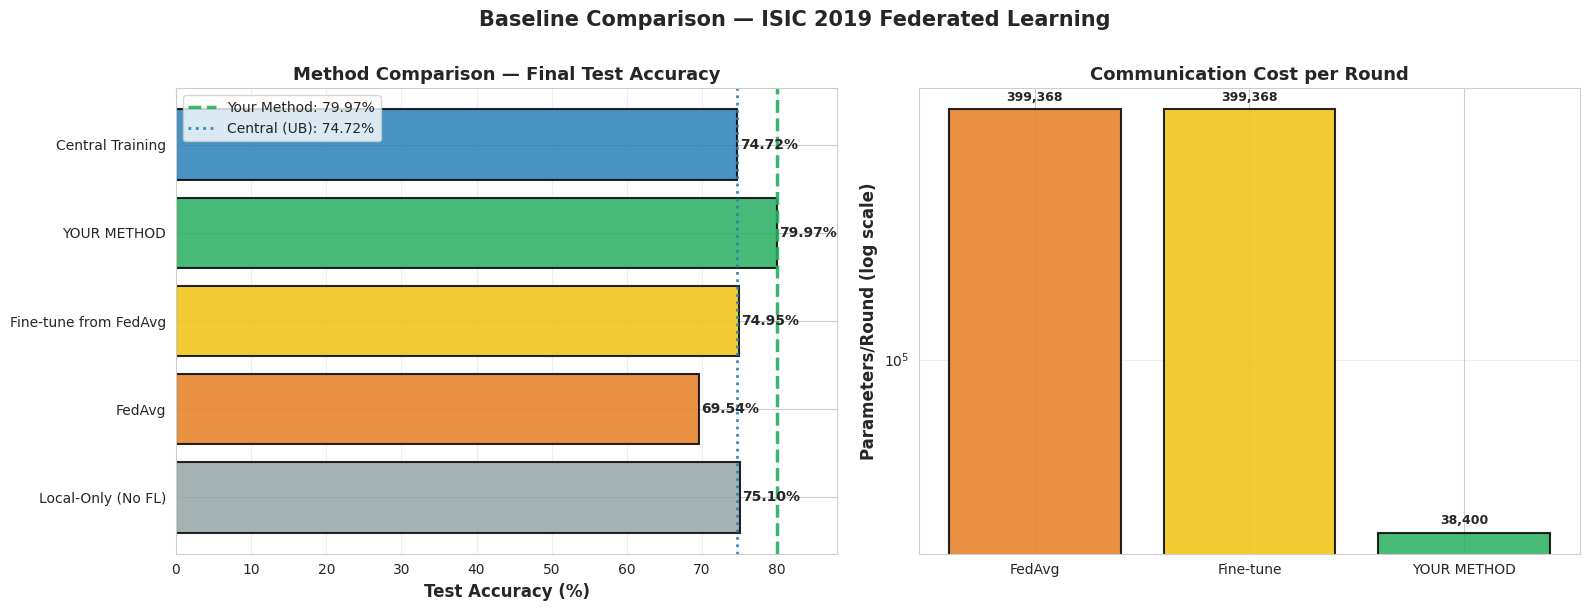

✓ Saved: viz1_accuracy_comparison.png


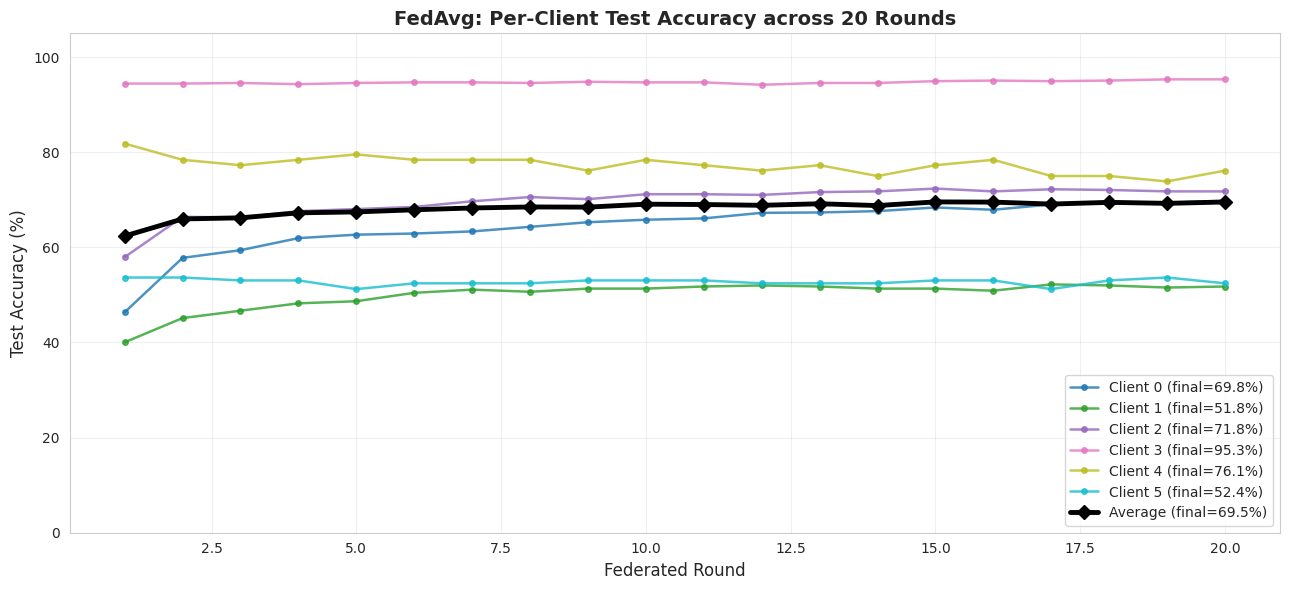

✓ Saved: viz2_fedavg_per_round.png


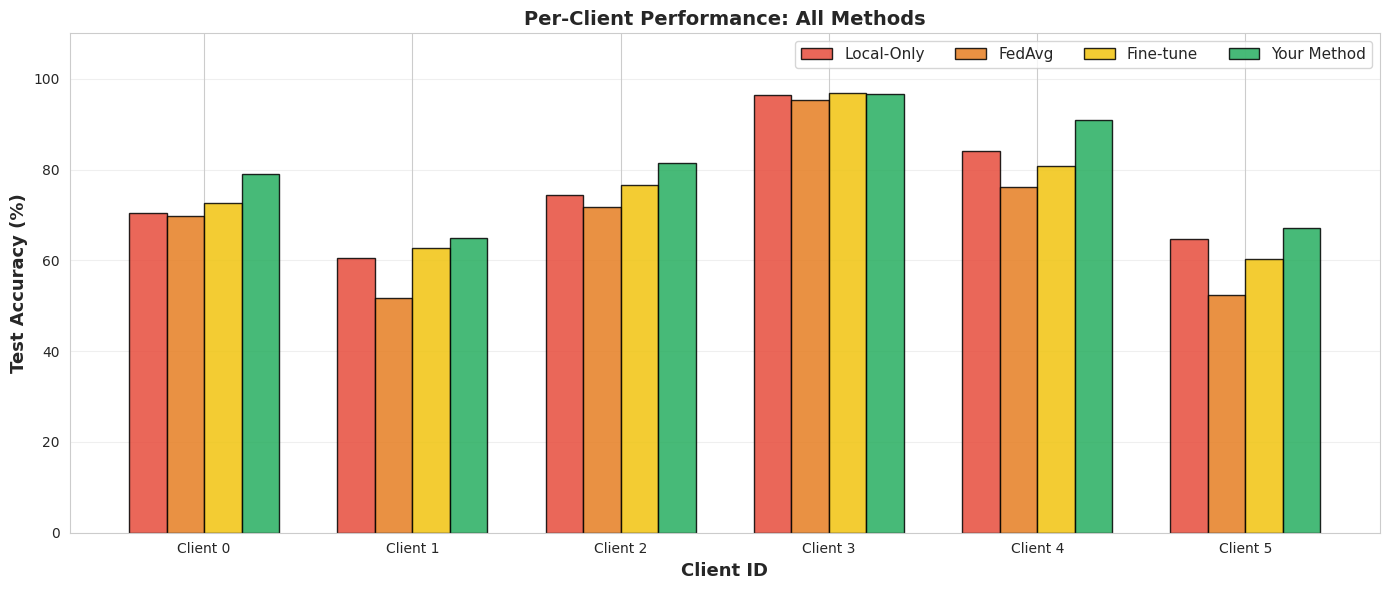

✓ Saved: viz3_per_client_comparison.png


In [ ]:
# ============================================================================
# CELL 13: COMPREHENSIVE VISUALIZATION
# Plots:
#   1. Accuracy comparison bar chart (all methods)
#   2. FedAvg test accuracy per client across 20 rounds
#   3. Per-client comparison (your method vs baselines)
#   4. Communication cost vs accuracy trade-off
#   5. Client heterogeneity (std dev per method)
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
Path('./experiment_logs').mkdir(exist_ok=True)

colors_methods = {
    'Local-Only'          : '#e74c3c',
    'FedAvg'              : '#e67e22',
    'Fine-tune from FedAvg': '#f1c40f',
    'YOUR METHOD'         : '#27ae60',
    'Central Training'    : '#2980b9'
}

# ── Figure 1: Overall Accuracy Comparison ─────────────────────────────
fig1, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax = axes[0]
methods_names = list(results_summary['Method'])
accuracies    = list(results_summary['Accuracy (%)'])
bar_colors    = [colors_methods.get(m, '#95a5a6') for m in methods_names]

bars = ax.barh(methods_names, accuracies, color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.5)

if your_final_acc:
    ax.axvline(x=your_final_acc, color='#27ae60', linestyle='--',
               linewidth=2.5, label=f'Your Method: {your_final_acc:.2f}%', alpha=0.9)
ax.axvline(x=central_acc, color='#2980b9', linestyle=':',
           linewidth=2, label=f'Central (UB): {central_acc:.2f}%', alpha=0.9)

for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
            f'{acc:.2f}%', va='center', fontweight='bold', fontsize=10)

ax.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Method Comparison — Final Test Accuracy', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(0, max(accuracies) + 8)

# Communication cost (log scale)
ax2 = axes[1]
comm_methods = ['FedAvg', 'Fine-tune', 'YOUR METHOD']
comm_vals    = [classifier_params, classifier_params, prompt_params]
comm_colors  = ['#e67e22', '#f1c40f', '#27ae60']

bars2 = ax2.bar(comm_methods, comm_vals, color=comm_colors, alpha=0.85, edgecolor='black', linewidth=1.5)
for bar, v in zip(bars2, comm_vals):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.05,
             f'{v:,}', ha='center', fontsize=9, fontweight='bold')

ax2.set_yscale('log')
ax2.set_ylabel('Parameters/Round (log scale)', fontsize=12, fontweight='bold')
ax2.set_title('Communication Cost per Round', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle('Baseline Comparison — DDR + APTOS Federated Learning',
             fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('./experiment_logs/viz1_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: viz1_accuracy_comparison.png')

# ── Figure 2: FedAvg test accuracy across 20 rounds (per client) ───────
if fedavg_server.results:
    fig2, ax = plt.subplots(figsize=(13, 6))
    round_nums   = [r['round'] for r in fedavg_server.results]
    fedavg_avgs  = [r['avg_acc'] for r in fedavg_server.results]
    client_colors = plt.cm.tab10(np.linspace(0, 1, num_clients))

    for i in range(num_clients):
        c_accs = [r['client_accs'][i] for r in fedavg_server.results]
        ax.plot(round_nums, c_accs,
                color=client_colors[i], linewidth=1.8,
                marker='o', markersize=4, alpha=0.8,
                label=f'Client {i} (final={c_accs[-1]:.1f}%)')

    ax.plot(round_nums, fedavg_avgs,
            color='black', linewidth=3.5,
            marker='D', markersize=7,
            label=f'Average (final={fedavg_avgs[-1]:.1f}%)', zorder=10)

    ax.set_title('FedAvg: Per-Client Test Accuracy across 20 Rounds',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Federated Round', fontsize=12)
    ax.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax.set_ylim(0, 105)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('./experiment_logs/viz2_fedavg_per_round.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✓ Saved: viz2_fedavg_per_round.png')

# ── Figure 3: Per-client comparison across all methods ─────────────────
fig3, ax = plt.subplots(figsize=(14, 6))

x        = np.arange(num_clients)
width    = 0.18
plot_methods_accs = [
    ('Local-Only',   local_results,    '#e74c3c'),
    ('FedAvg',       fedavg_client_accs, '#e67e22'),
    ('Fine-tune',    finetune_results,  '#f1c40f'),
]
if your_client_accs:
    plot_methods_accs.append(('Your Method', your_client_accs, '#27ae60'))

n_methods = len(plot_methods_accs)
for idx, (mname, maccs, mcolor) in enumerate(plot_methods_accs):
    offset = (idx - n_methods / 2 + 0.5) * width
    ax.bar(x + offset, maccs, width, label=mname,
           color=mcolor, alpha=0.85, edgecolor='black', linewidth=1)

ax.set_xlabel('Client ID', fontsize=13, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Per-Client Performance: All Methods', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Client {i}' for i in range(num_clients)])
ax.legend(fontsize=11, ncol=4)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 110)

plt.tight_layout()
plt.savefig('./experiment_logs/viz3_per_client_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: viz3_per_client_comparison.png')

In [ ]:
# ============================================================================
# CELL 14: FINAL SUMMARY PRINTOUT
# ============================================================================

print('\n' + '=' * 70)
print('FINAL SUMMARY — ALL BASELINES')
print('=' * 70)

print(f'{"Method":<25} {"Avg Acc":>10} {"Std Dev":>10} {"vs FedAvg":>12}')
print('-' * 60)

all_methods = [
    ('Local-Only',          avg_local,     std_local),
    ('FedAvg',              fedavg_final,  fedavg_std),
    ('Fine-tune (FedAvg)',  finetune_avg,  finetune_std),
    ('Central (Upper Bnd)', central_acc,   0.0),
]
if your_final_acc:
    all_methods.append(('YOUR METHOD', your_final_acc, your_std or 0.0))

all_methods.sort(key=lambda x: x[1], reverse=True)

for mname, macc, mstd in all_methods:
    vs_fedavg = macc - fedavg_final
    vs_str    = f'+{vs_fedavg:.2f}%' if vs_fedavg >= 0 else f'{vs_fedavg:.2f}%'
    print(f'{mname:<25} {macc:>9.2f}%  {mstd:>9.2f}%  {vs_str:>12}')

print('=' * 70)

print('\n📋 NOTES FOR PAPER:')
print(f'  All baselines use SAME frozen ViT-Base/16 backbone (ImageNet-21k)')
print(f'  All baselines train ONLY classifier head ({sum(p.numel() for p in fedavg_server.global_model.classifier.parameters()):,} params)')
print(f'  Your method communicates only prompts ({prompt_params:,} params/round)')
print(f'  All methods use patience=3 on val_loss — same stopping criterion')
print(f'  max_epochs=10, min_epochs=2 for all methods')
print('=' * 70)


FINAL SUMMARY — ALL BASELINES
Method                       Avg Acc    Std Dev    vs FedAvg
------------------------------------------------------------
YOUR METHOD                   79.97%      11.51%       +10.43%
Local-Only                    75.10%      12.10%        +5.56%
Fine-tune (FedAvg)            74.95%      12.14%        +5.41%
Central (Upper Bnd)           74.72%       0.00%        +5.18%
FedAvg                        69.54%      14.84%        +0.00%

📋 NOTES FOR PAPER:
  All baselines use SAME frozen ViT-Base/16 backbone (ImageNet-21k)
  All baselines train ONLY classifier head (399,368 params)
  Your method communicates only prompts (38,400 params/round)
  All methods use patience=3 on val_loss — same stopping criterion
  max_epochs=10, min_epochs=2 for all methods


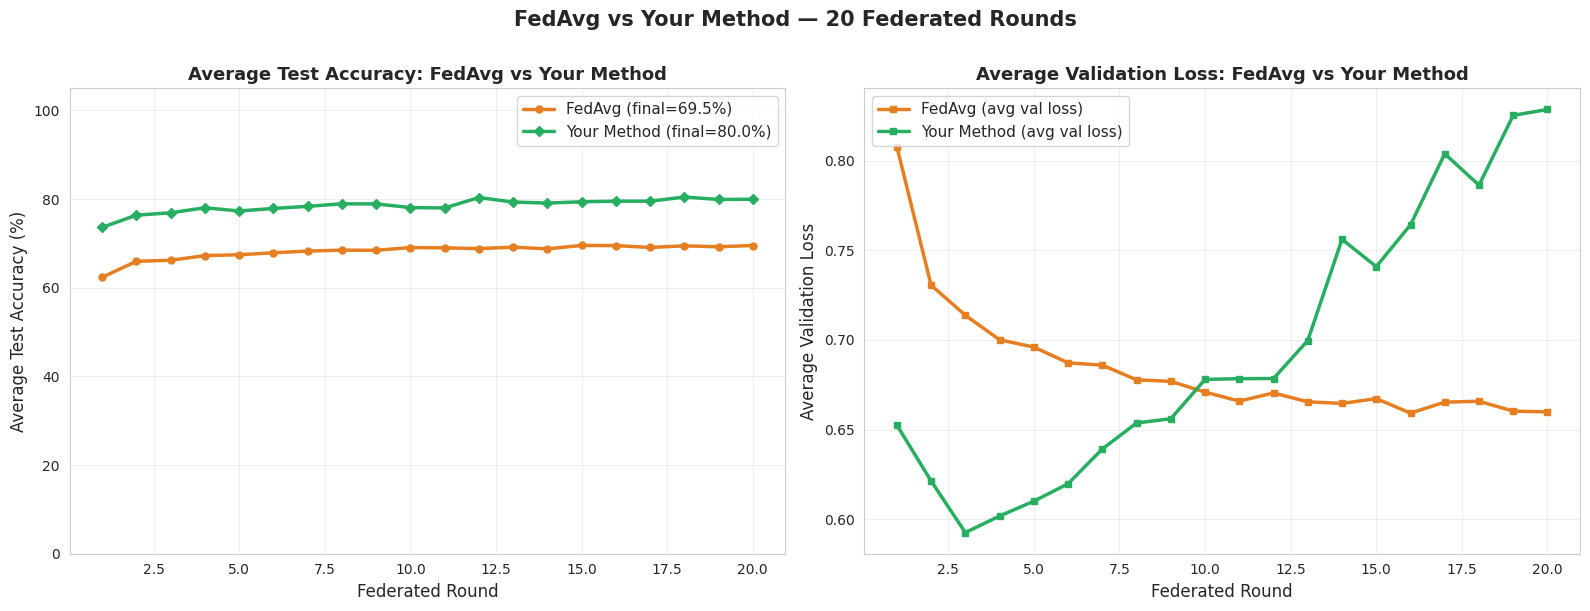

✓ Saved: viz4_fedavg_vs_yourmethod.png


In [ ]:
# ============================================================================
# CELL 15: COMPARE FEDAVG vs YOUR METHOD across 20 rounds
# Reads JSON logs from both methods and overlays on one plot
# ============================================================================

import glob

def plot_method_comparison(log_dir='./experiment_logs'):
    """
    Overlay FedAvg and proposed method avg accuracy across rounds.
    Both methods log in same JSON format so this works directly.
    """
    # ── Find log files ─────────────────────────────────────────────
    fedavg_logs  = sorted(glob.glob(f'{log_dir}/baseline_fedavg*.json'))
    your_logs    = sorted(glob.glob(f'{log_dir}/pFedPG*.json'))

    if not fedavg_logs:
        print('⚠ No FedAvg log found')
        return

    with open(fedavg_logs[-1]) as f:
        fedavg_data = json.load(f)

    your_data = None
    if your_logs:
        with open(your_logs[-1]) as f:
            your_data = json.load(f)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ── Left: Average accuracy comparison ─────────────────────────
    ax = axes[0]

    fedavg_rounds   = [r['round'] for r in fedavg_data['rounds']]
    fedavg_avg_accs = [r['avg_acc'] for r in fedavg_data['rounds']]

    ax.plot(fedavg_rounds, fedavg_avg_accs,
            color='#e67e22', linewidth=2.5, marker='o', markersize=5,
            label=f'FedAvg (final={fedavg_avg_accs[-1]:.1f}%)')

    if your_data and your_data.get('rounds'):
        your_rounds   = [r['round'] for r in your_data['rounds']]
        your_avg_accs = [r['avg_acc'] for r in your_data['rounds']]
        ax.plot(your_rounds, your_avg_accs,
                color='#27ae60', linewidth=2.5, marker='D', markersize=5,
                label=f'Your Method (final={your_avg_accs[-1]:.1f}%)')

    ax.set_title('Average Test Accuracy: FedAvg vs Your Method',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Federated Round', fontsize=12)
    ax.set_ylabel('Average Test Accuracy (%)', fontsize=12)
    ax.set_ylim(0, 105)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # ── Right: Val loss comparison ─────────────────────────────────
    ax2 = axes[1]

    if 'validation_losses' in fedavg_data['rounds'][0]:
        # Average val loss per round
        fedavg_avg_vl = [
            np.mean(r['validation_losses'])
            for r in fedavg_data['rounds']
        ]
        ax2.plot(fedavg_rounds, fedavg_avg_vl,
                 color='#e67e22', linewidth=2.5, marker='s', markersize=5,
                 label='FedAvg (avg val loss)')

    if your_data and your_data.get('rounds') and 'validation_losses' in your_data['rounds'][0]:
        your_avg_vl = [
            np.mean(r['validation_losses'])
            for r in your_data['rounds']
        ]
        ax2.plot(your_rounds, your_avg_vl,
                 color='#27ae60', linewidth=2.5, marker='s', markersize=5,
                 label='Your Method (avg val loss)')

    ax2.set_title('Average Validation Loss: FedAvg vs Your Method',
                  fontsize=13, fontweight='bold')
    ax2.set_xlabel('Federated Round', fontsize=12)
    ax2.set_ylabel('Average Validation Loss', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.suptitle('FedAvg vs Your Method — 20 Federated Rounds',
                 fontsize=15, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig(f'{log_dir}/viz4_fedavg_vs_yourmethod.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✓ Saved: viz4_fedavg_vs_yourmethod.png')


plot_method_comparison(log_dir='./experiment_logs')